# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 2.8MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

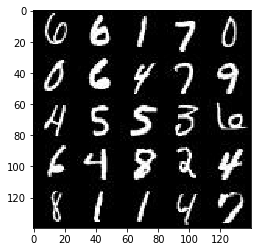

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

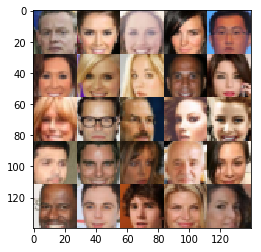

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    lr=tf.placeholder(dtype=tf.float32,name='learning_rate')
    input_image=tf.placeholder(dtype=tf.float32,shape=[None,image_width,image_height,image_channels],name='input_image')
    z=tf.placeholder(dtype=tf.float32,shape=[None,z_dim],name='z')

    return input_image, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
from tensorflow.contrib.layers import xavier_initializer
def discriminator(images, reuse=False,training=True,alpha=0.01, keep_prob =0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        
        first_layer=tf.contrib.layers.conv2d(images,64,5,stride=2,padding='same',activation_fn=None,weights_initializer=xavier_initializer())
        first_layer=tf.maximum(first_layer,alpha*first_layer)
        
        second_layer=tf.contrib.layers.conv2d(first_layer,128,5,stride=2,padding='same',activation_fn=None,weights_initializer=xavier_initializer())
        second_layer=tf.layers.batch_normalization(second_layer,training=training)
        second_layer=tf.maximum(second_layer,alpha*second_layer)
        
        third_layer=tf.contrib.layers.conv2d(second_layer,256,5,stride=2,padding='same',activation_fn=None,weights_initializer=xavier_initializer())
        third_layer=tf.layers.batch_normalization(third_layer,training=training)
        third_layer=tf.maximum(third_layer,alpha*third_layer)
        
        forth_layer=tf.contrib.layers.conv2d(third_layer,512,5,stride=2,padding='same',activation_fn=None,weights_initializer=xavier_initializer())
        forth_layer=tf.layers.batch_normalization(forth_layer,training=training)
        forth_layer=tf.maximum(forth_layer,alpha*forth_layer)
        flatten = tf.reshape(forth_layer, (-1, 2*2*512))
        
        dropout=tf.nn.dropout(flatten, keep_prob =keep_prob)
        logits = tf.contrib.layers.fully_connected(flatten,1,activation_fn=None,weights_initializer=xavier_initializer())
        out =tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim,is_train=True,keep_prob=1,alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        
        first_layer=tf.contrib.layers.fully_connected(z,3*3*1024,activation_fn=None,weights_initializer=xavier_initializer())
        first_layer=tf.reshape(first_layer,(-1,3,3,1024))
        first_layer=tf.layers.batch_normalization(first_layer,training=is_train)
        first_layer=tf.maximum(first_layer,alpha*first_layer)
        
        second_layer=tf.nn.dropout(first_layer, keep_prob =keep_prob)
        second_layer=tf.contrib.layers.conv2d_transpose(first_layer,512,3,stride=2,padding='valid',activation_fn=None,weights_initializer=xavier_initializer())
        second_layer=tf.layers.batch_normalization(second_layer,training=is_train)
        second_layer=tf.maximum(second_layer,alpha*second_layer)
        
        second_layer_=tf.nn.dropout(second_layer, keep_prob =keep_prob)
        second_layer_=tf.contrib.layers.conv2d_transpose(second_layer,256,5,stride=1,padding='valid',activation_fn=None,weights_initializer=xavier_initializer())
        second_layer_=tf.layers.batch_normalization(second_layer_,training=is_train)
        second_layer_=tf.maximum(second_layer_,alpha*second_layer_)
        
        third_layer=tf.nn.dropout(second_layer_, keep_prob =keep_prob)
        third_layer=tf.contrib.layers.conv2d_transpose(second_layer,128,4,stride=2,padding='same',activation_fn=None,weights_initializer=xavier_initializer())
        third_layer=tf.layers.batch_normalization(third_layer,training=is_train)
        third_layer=tf.maximum(third_layer,alpha*third_layer)
        
        forth_layer=tf.nn.dropout(third_layer, keep_prob =keep_prob)
        forth_layer=tf.contrib.layers.conv2d_transpose(third_layer,out_channel_dim,4,stride=2,padding='same',activation_fn=None,weights_initializer=xavier_initializer())
        forth_layer=tf.tanh(forth_layer)
#         print(forth_layer.shape)
        
        
    return forth_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.01,smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_output=generator(input_z, out_channel_dim, is_train=True)
    d_true_label,d_true_logits=discriminator(input_real, reuse=False,alpha=alpha)
    d_fake_label,d_fake_logits=discriminator(generator_output, reuse=True,alpha=alpha)
    
    d_loss_real= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_true_logits,labels=tf.ones_like(d_true_label)*(1 - smooth)))                   
#     d_loss_real= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_true_logits,labels=tf.ones_like(d_true_label)))    
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_label)))
    
    d_loss=d_loss_real+d_loss_fake
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.ones_like(d_fake_label)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    g_vars=[trainable_var for trainable_var in tf.trainable_variables() if trainable_var.name.startswith('generator')]
    d_vars=[trainable_var for trainable_var in tf.trainable_variables() if trainable_var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_optimizer=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_optimizer,g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,alpha=0.1,print_every=20,show_every=200):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real,input_z,lr=model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss=model_loss(input_real, input_z, data_shape[3])
    d_optimizer,g_optimizer=model_opt(d_loss, g_loss, lr, beta1)
    
    saver=tf.train.Saver()
    sample_z=np.random.uniform(-1,1,size=(10,z_dim))
    samples,losses=[],[]
    steps=0
    
 
    with tf.Session() as sess:
        k=0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #scale the image value to be between -1 ,1
                batch_images=batch_images*2
                # TODO: Train Model
                steps+=1
                #sample random noise for G
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                #run optimizer
                _=sess.run(d_optimizer,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                _=sess.run(g_optimizer,feed_dict={input_z:batch_z,input_real:batch_images,lr:learning_rate})
                _=sess.run(g_optimizer,feed_dict={input_z:batch_z,input_real:batch_images,lr:learning_rate})


                    
                if steps % print_every==0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d,train_loss_g))
                if steps%show_every==0:
                    show_generator_output(sess, 10, input_z, batch_images.shape[3], data_image_mode)
        saver.save(sess,'./checkpoints/generator.ckpt')
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 2.8152
Epoch 1/2... Discriminator Loss: 1.5750... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 0.4621
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 1.8503... Generator Loss: 0.2960
Epoch 1/2... Discriminator Loss: 1.7086... Generator Loss: 0.3274
Epoch 1/2... Discriminator Loss: 1.6946... Generator Loss: 0.3331
Epoch 1/2... Discriminator Loss: 2.1186... Generator Loss: 0.2014
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.8329


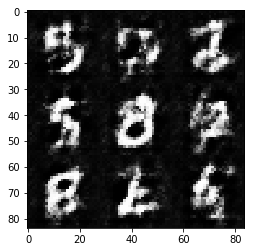

Epoch 1/2... Discriminator Loss: 1.8524... Generator Loss: 1.7788
Epoch 1/2... Discriminator Loss: 1.7363... Generator Loss: 0.3469
Epoch 1/2... Discriminator Loss: 1.9867... Generator Loss: 0.2786
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 1.7063... Generator Loss: 0.3283
Epoch 1/2... Discriminator Loss: 2.2277... Generator Loss: 0.1893
Epoch 1/2... Discriminator Loss: 2.2602... Generator Loss: 0.1750
Epoch 1/2... Discriminator Loss: 1.6892... Generator Loss: 0.3842
Epoch 1/2... Discriminator Loss: 2.1913... Generator Loss: 0.2174
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.7607


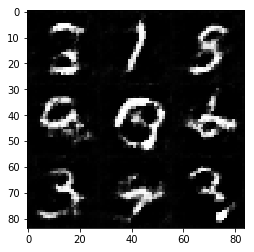

Epoch 1/2... Discriminator Loss: 1.7835... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 1.6875... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.6462... Generator Loss: 1.1015
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.6756
Epoch 1/2... Discriminator Loss: 1.7391... Generator Loss: 0.3375
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.6847
Epoch 1/2... Discriminator Loss: 1.8807... Generator Loss: 0.2711
Epoch 1/2... Discriminator Loss: 2.1948... Generator Loss: 0.1986


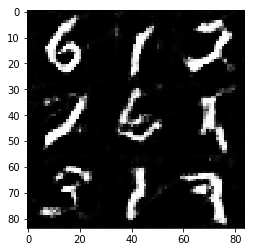

Epoch 1/2... Discriminator Loss: 2.5887... Generator Loss: 0.1421
Epoch 1/2... Discriminator Loss: 1.6995... Generator Loss: 0.3534
Epoch 1/2... Discriminator Loss: 2.1001... Generator Loss: 0.2143
Epoch 1/2... Discriminator Loss: 1.2103... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 2.2626... Generator Loss: 0.1829
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.4685
Epoch 1/2... Discriminator Loss: 1.6549... Generator Loss: 0.4595
Epoch 1/2... Discriminator Loss: 1.9810... Generator Loss: 0.2424
Epoch 1/2... Discriminator Loss: 2.1644... Generator Loss: 0.2284
Epoch 1/2... Discriminator Loss: 1.9128... Generator Loss: 0.2867


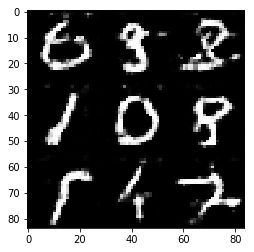

Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.5508
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.4953
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.6560
Epoch 1/2... Discriminator Loss: 1.9727... Generator Loss: 0.2799
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 1.0523
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 2.0541... Generator Loss: 0.2551
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 1.5136
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 1.9960... Generator Loss: 0.2568


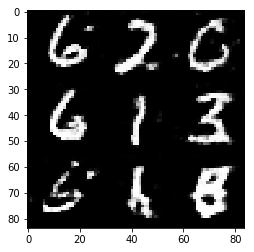

Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.4425
Epoch 1/2... Discriminator Loss: 2.0846... Generator Loss: 0.2298
Epoch 1/2... Discriminator Loss: 1.6450... Generator Loss: 0.4106
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.4774
Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.5846... Generator Loss: 0.4654
Epoch 1/2... Discriminator Loss: 1.7667... Generator Loss: 0.3316
Epoch 1/2... Discriminator Loss: 1.8094... Generator Loss: 0.2951
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.5163
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.5065


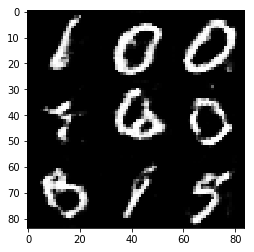

Epoch 1/2... Discriminator Loss: 2.1378... Generator Loss: 0.2049
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.7977... Generator Loss: 0.3498
Epoch 1/2... Discriminator Loss: 1.6052... Generator Loss: 0.4961
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.6612... Generator Loss: 0.3444
Epoch 1/2... Discriminator Loss: 1.9105... Generator Loss: 0.2703
Epoch 1/2... Discriminator Loss: 1.7618... Generator Loss: 0.3062
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.9745... Generator Loss: 0.2609


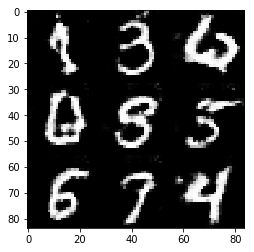

Epoch 1/2... Discriminator Loss: 2.2109... Generator Loss: 0.1931
Epoch 1/2... Discriminator Loss: 1.9140... Generator Loss: 0.2668
Epoch 1/2... Discriminator Loss: 2.1637... Generator Loss: 0.2169
Epoch 1/2... Discriminator Loss: 1.8888... Generator Loss: 0.3042
Epoch 1/2... Discriminator Loss: 1.9418... Generator Loss: 0.2511
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.5717
Epoch 1/2... Discriminator Loss: 2.6470... Generator Loss: 0.1334
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 1.7219... Generator Loss: 0.3172
Epoch 1/2... Discriminator Loss: 2.1366... Generator Loss: 0.2048


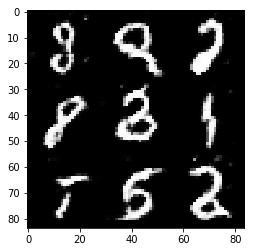

Epoch 1/2... Discriminator Loss: 1.6616... Generator Loss: 0.3839
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.5201
Epoch 1/2... Discriminator Loss: 2.0857... Generator Loss: 0.2302
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 1.0630
Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 0.4177
Epoch 1/2... Discriminator Loss: 1.6133... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.4221
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 2.0463... Generator Loss: 0.2237
Epoch 1/2... Discriminator Loss: 2.0842... Generator Loss: 0.2194


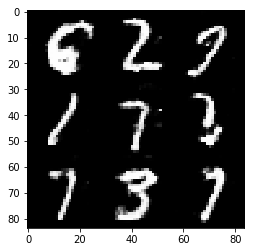

Epoch 1/2... Discriminator Loss: 1.5118... Generator Loss: 0.4217
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.4352
Epoch 1/2... Discriminator Loss: 2.5287... Generator Loss: 0.1378
Epoch 2/2... Discriminator Loss: 2.5475... Generator Loss: 0.1388
Epoch 2/2... Discriminator Loss: 1.8635... Generator Loss: 0.2668
Epoch 2/2... Discriminator Loss: 1.6603... Generator Loss: 0.3495
Epoch 2/2... Discriminator Loss: 2.0057... Generator Loss: 0.2400
Epoch 2/2... Discriminator Loss: 1.5373... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 1.8323... Generator Loss: 0.3036
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.3969


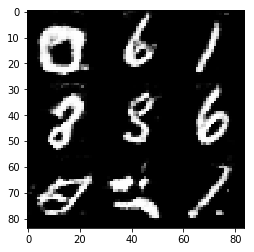

Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.5518
Epoch 2/2... Discriminator Loss: 2.1602... Generator Loss: 0.1963
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 2.1095... Generator Loss: 0.2068
Epoch 2/2... Discriminator Loss: 1.7916... Generator Loss: 0.3250
Epoch 2/2... Discriminator Loss: 2.1385... Generator Loss: 0.2185
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 2.0976... Generator Loss: 0.2073
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.4507


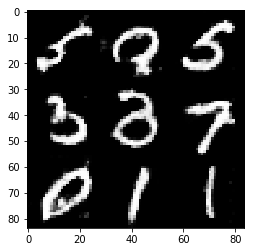

Epoch 2/2... Discriminator Loss: 1.8340... Generator Loss: 0.2862
Epoch 2/2... Discriminator Loss: 1.8546... Generator Loss: 0.2921
Epoch 2/2... Discriminator Loss: 1.5929... Generator Loss: 0.3974
Epoch 2/2... Discriminator Loss: 1.8523... Generator Loss: 0.2683
Epoch 2/2... Discriminator Loss: 2.2637... Generator Loss: 0.1797
Epoch 2/2... Discriminator Loss: 2.6991... Generator Loss: 0.1417
Epoch 2/2... Discriminator Loss: 1.8052... Generator Loss: 0.3052
Epoch 2/2... Discriminator Loss: 2.3728... Generator Loss: 0.1761
Epoch 2/2... Discriminator Loss: 2.1630... Generator Loss: 0.2101
Epoch 2/2... Discriminator Loss: 1.5457... Generator Loss: 0.4135


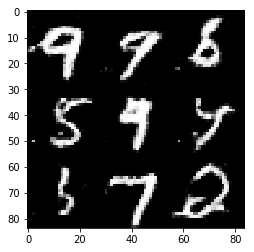

Epoch 2/2... Discriminator Loss: 1.9398... Generator Loss: 0.2606
Epoch 2/2... Discriminator Loss: 2.2266... Generator Loss: 0.2136
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 1.8874... Generator Loss: 0.2729
Epoch 2/2... Discriminator Loss: 2.0266... Generator Loss: 0.2536
Epoch 2/2... Discriminator Loss: 2.1117... Generator Loss: 0.2515
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.4585
Epoch 2/2... Discriminator Loss: 1.4746... Generator Loss: 0.5026
Epoch 2/2... Discriminator Loss: 1.9345... Generator Loss: 0.2522
Epoch 2/2... Discriminator Loss: 2.1147... Generator Loss: 0.2335


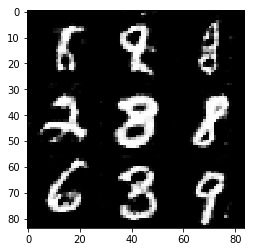

Epoch 2/2... Discriminator Loss: 2.5797... Generator Loss: 0.1362
Epoch 2/2... Discriminator Loss: 1.7223... Generator Loss: 0.3465
Epoch 2/2... Discriminator Loss: 2.0200... Generator Loss: 0.2418
Epoch 2/2... Discriminator Loss: 1.7795... Generator Loss: 0.3419
Epoch 2/2... Discriminator Loss: 1.6895... Generator Loss: 0.3274
Epoch 2/2... Discriminator Loss: 2.4885... Generator Loss: 0.1600
Epoch 2/2... Discriminator Loss: 1.9969... Generator Loss: 0.2361
Epoch 2/2... Discriminator Loss: 1.5205... Generator Loss: 0.4343
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.5008
Epoch 2/2... Discriminator Loss: 1.7207... Generator Loss: 0.3283


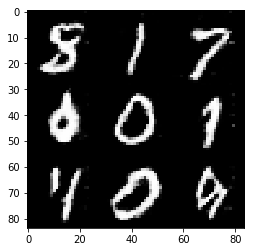

Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 0.8350... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 1.5480
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.5131
Epoch 2/2... Discriminator Loss: 1.9133... Generator Loss: 0.2592
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.5403
Epoch 2/2... Discriminator Loss: 1.5641... Generator Loss: 0.4067
Epoch 2/2... Discriminator Loss: 1.7323... Generator Loss: 0.3185
Epoch 2/2... Discriminator Loss: 2.7882... Generator Loss: 0.1468


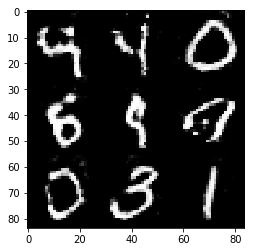

Epoch 2/2... Discriminator Loss: 1.5121... Generator Loss: 0.4264
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.5469
Epoch 2/2... Discriminator Loss: 2.7977... Generator Loss: 0.1191
Epoch 2/2... Discriminator Loss: 1.8974... Generator Loss: 0.2895
Epoch 2/2... Discriminator Loss: 1.9945... Generator Loss: 0.2798
Epoch 2/2... Discriminator Loss: 1.4732... Generator Loss: 0.4119
Epoch 2/2... Discriminator Loss: 1.9768... Generator Loss: 0.2557
Epoch 2/2... Discriminator Loss: 2.0963... Generator Loss: 0.2252
Epoch 2/2... Discriminator Loss: 3.7892... Generator Loss: 0.0511
Epoch 2/2... Discriminator Loss: 1.4913... Generator Loss: 0.4282


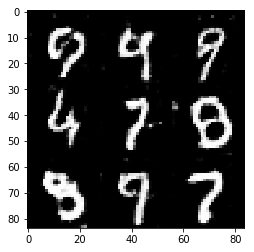

Epoch 2/2... Discriminator Loss: 1.5843... Generator Loss: 0.3812
Epoch 2/2... Discriminator Loss: 3.0335... Generator Loss: 0.0990
Epoch 2/2... Discriminator Loss: 1.4614... Generator Loss: 0.4490
Epoch 2/2... Discriminator Loss: 1.6569... Generator Loss: 0.3490
Epoch 2/2... Discriminator Loss: 1.5699... Generator Loss: 0.4058
Epoch 2/2... Discriminator Loss: 1.5964... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 0.5086
Epoch 2/2... Discriminator Loss: 2.0125... Generator Loss: 0.2351
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.5527
Epoch 2/2... Discriminator Loss: 1.6462... Generator Loss: 0.3593


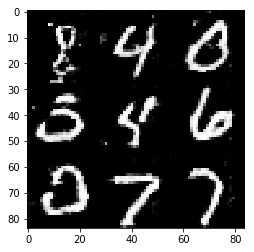

Epoch 2/2... Discriminator Loss: 2.5354... Generator Loss: 0.2125
Epoch 2/2... Discriminator Loss: 1.7535... Generator Loss: 0.3066
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 1.4878... Generator Loss: 0.4534
Epoch 2/2... Discriminator Loss: 2.0313... Generator Loss: 0.2272
Epoch 2/2... Discriminator Loss: 1.7402... Generator Loss: 0.3397
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.4890
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 2.0580... Generator Loss: 0.2550
Epoch 2/2... Discriminator Loss: 2.1565... Generator Loss: 0.2158


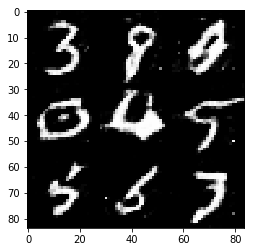

Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 1.7012... Generator Loss: 0.3358
Epoch 2/2... Discriminator Loss: 1.8626... Generator Loss: 2.7430
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.4982
Epoch 2/2... Discriminator Loss: 1.7453... Generator Loss: 0.3337
Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.6470
Epoch 2/2... Discriminator Loss: 2.0765... Generator Loss: 0.2210


In [12]:
import numpy as np
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    

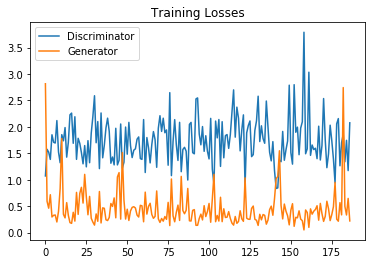

In [14]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 2.1954
Epoch 1/1... Discriminator Loss: 2.0121... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.9923... Generator Loss: 0.3164
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 2.6918... Generator Loss: 0.1262
Epoch 1/1... Discriminator Loss: 2.6326... Generator Loss: 0.1432
Epoch 1/1... Discriminator Loss: 2.1638... Generator Loss: 0.2948
Epoch 1/1... Discriminator Loss: 2.7875... Generator Loss: 0.1454
Epoch 1/1... Discriminator Loss: 1.7742... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 2.5753... Generator Loss: 0.1248


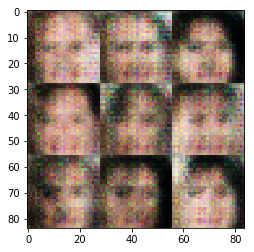

Epoch 1/1... Discriminator Loss: 1.9001... Generator Loss: 0.3148
Epoch 1/1... Discriminator Loss: 2.3298... Generator Loss: 0.1853
Epoch 1/1... Discriminator Loss: 2.0854... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 2.1309... Generator Loss: 0.3353
Epoch 1/1... Discriminator Loss: 1.6395... Generator Loss: 0.4380
Epoch 1/1... Discriminator Loss: 1.9718... Generator Loss: 0.2912
Epoch 1/1... Discriminator Loss: 2.2315... Generator Loss: 0.2659
Epoch 1/1... Discriminator Loss: 2.1203... Generator Loss: 0.2490


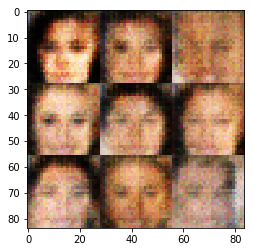

Epoch 1/1... Discriminator Loss: 1.9510... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 2.0394... Generator Loss: 0.2838
Epoch 1/1... Discriminator Loss: 2.4458... Generator Loss: 0.1782
Epoch 1/1... Discriminator Loss: 1.8324... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 2.3305... Generator Loss: 0.2132
Epoch 1/1... Discriminator Loss: 2.0062... Generator Loss: 0.2667
Epoch 1/1... Discriminator Loss: 1.8023... Generator Loss: 0.3359
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 2.1199... Generator Loss: 0.2210
Epoch 1/1... Discriminator Loss: 2.0509... Generator Loss: 0.2612


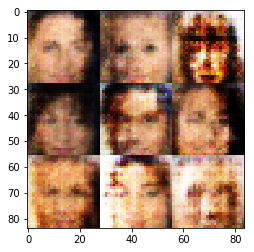

Epoch 1/1... Discriminator Loss: 2.3360... Generator Loss: 0.1929
Epoch 1/1... Discriminator Loss: 2.1792... Generator Loss: 0.2183
Epoch 1/1... Discriminator Loss: 2.5747... Generator Loss: 0.1406
Epoch 1/1... Discriminator Loss: 2.3199... Generator Loss: 0.1981
Epoch 1/1... Discriminator Loss: 2.6553... Generator Loss: 0.1186
Epoch 1/1... Discriminator Loss: 1.8778... Generator Loss: 0.3171
Epoch 1/1... Discriminator Loss: 2.5263... Generator Loss: 0.1557
Epoch 1/1... Discriminator Loss: 2.2117... Generator Loss: 0.1987
Epoch 1/1... Discriminator Loss: 2.5005... Generator Loss: 0.1533
Epoch 1/1... Discriminator Loss: 2.2137... Generator Loss: 0.2459


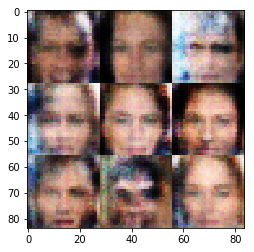

Epoch 1/1... Discriminator Loss: 2.1698... Generator Loss: 0.2400
Epoch 1/1... Discriminator Loss: 2.0021... Generator Loss: 0.2514
Epoch 1/1... Discriminator Loss: 2.7086... Generator Loss: 0.1233
Epoch 1/1... Discriminator Loss: 2.1425... Generator Loss: 0.2036
Epoch 1/1... Discriminator Loss: 1.9982... Generator Loss: 0.2836
Epoch 1/1... Discriminator Loss: 2.3720... Generator Loss: 0.1788
Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 0.3089
Epoch 1/1... Discriminator Loss: 3.1443... Generator Loss: 0.0708
Epoch 1/1... Discriminator Loss: 1.7962... Generator Loss: 0.3656
Epoch 1/1... Discriminator Loss: 2.5870... Generator Loss: 0.1433


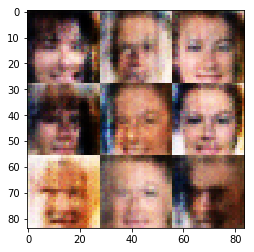

Epoch 1/1... Discriminator Loss: 2.6104... Generator Loss: 0.1248
Epoch 1/1... Discriminator Loss: 1.9582... Generator Loss: 0.2834
Epoch 1/1... Discriminator Loss: 2.4842... Generator Loss: 0.1946
Epoch 1/1... Discriminator Loss: 2.4535... Generator Loss: 0.1479
Epoch 1/1... Discriminator Loss: 2.1793... Generator Loss: 0.2493
Epoch 1/1... Discriminator Loss: 2.0144... Generator Loss: 0.3316
Epoch 1/1... Discriminator Loss: 2.5058... Generator Loss: 0.1570
Epoch 1/1... Discriminator Loss: 2.0640... Generator Loss: 0.2471
Epoch 1/1... Discriminator Loss: 2.6106... Generator Loss: 0.1389
Epoch 1/1... Discriminator Loss: 1.8973... Generator Loss: 0.2862


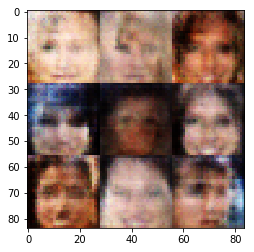

Epoch 1/1... Discriminator Loss: 1.8132... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 2.1681... Generator Loss: 0.1935
Epoch 1/1... Discriminator Loss: 2.3682... Generator Loss: 0.1748
Epoch 1/1... Discriminator Loss: 1.9220... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 2.5596... Generator Loss: 0.1654
Epoch 1/1... Discriminator Loss: 2.2366... Generator Loss: 0.1982
Epoch 1/1... Discriminator Loss: 2.2177... Generator Loss: 0.2069
Epoch 1/1... Discriminator Loss: 2.3020... Generator Loss: 0.2049
Epoch 1/1... Discriminator Loss: 2.6356... Generator Loss: 0.1212
Epoch 1/1... Discriminator Loss: 2.0519... Generator Loss: 0.2665


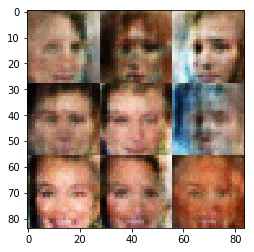

Epoch 1/1... Discriminator Loss: 2.3582... Generator Loss: 0.1598
Epoch 1/1... Discriminator Loss: 2.2483... Generator Loss: 0.1895
Epoch 1/1... Discriminator Loss: 2.8864... Generator Loss: 0.0990
Epoch 1/1... Discriminator Loss: 1.8722... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 2.3117... Generator Loss: 0.1719
Epoch 1/1... Discriminator Loss: 1.7514... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 2.2460... Generator Loss: 0.1923
Epoch 1/1... Discriminator Loss: 2.4847... Generator Loss: 0.1588
Epoch 1/1... Discriminator Loss: 2.4442... Generator Loss: 0.1577
Epoch 1/1... Discriminator Loss: 3.1030... Generator Loss: 0.0818


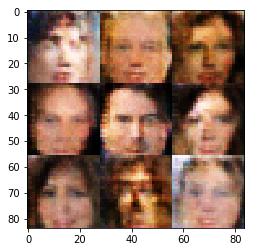

Epoch 1/1... Discriminator Loss: 1.9886... Generator Loss: 0.2550
Epoch 1/1... Discriminator Loss: 2.0147... Generator Loss: 0.3210
Epoch 1/1... Discriminator Loss: 2.1159... Generator Loss: 0.2370
Epoch 1/1... Discriminator Loss: 2.3879... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 2.6683... Generator Loss: 0.1096
Epoch 1/1... Discriminator Loss: 2.7572... Generator Loss: 0.1146
Epoch 1/1... Discriminator Loss: 2.6541... Generator Loss: 0.1320
Epoch 1/1... Discriminator Loss: 1.7233... Generator Loss: 0.3447
Epoch 1/1... Discriminator Loss: 2.1929... Generator Loss: 0.2333
Epoch 1/1... Discriminator Loss: 2.0656... Generator Loss: 0.3264


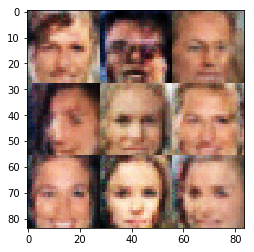

Epoch 1/1... Discriminator Loss: 1.7632... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 2.4326... Generator Loss: 0.1529
Epoch 1/1... Discriminator Loss: 2.4580... Generator Loss: 0.1494
Epoch 1/1... Discriminator Loss: 2.3494... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 1.9206... Generator Loss: 0.2917
Epoch 1/1... Discriminator Loss: 2.3512... Generator Loss: 0.1700
Epoch 1/1... Discriminator Loss: 2.2124... Generator Loss: 0.2231
Epoch 1/1... Discriminator Loss: 2.1296... Generator Loss: 0.2316
Epoch 1/1... Discriminator Loss: 2.5996... Generator Loss: 0.1212
Epoch 1/1... Discriminator Loss: 2.5349... Generator Loss: 0.1732


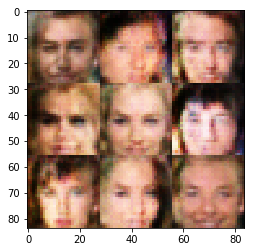

Epoch 1/1... Discriminator Loss: 2.0873... Generator Loss: 0.2221
Epoch 1/1... Discriminator Loss: 2.4804... Generator Loss: 0.1677
Epoch 1/1... Discriminator Loss: 2.3269... Generator Loss: 0.1716
Epoch 1/1... Discriminator Loss: 2.5606... Generator Loss: 0.1396
Epoch 1/1... Discriminator Loss: 2.8400... Generator Loss: 0.0978
Epoch 1/1... Discriminator Loss: 2.1292... Generator Loss: 0.2365
Epoch 1/1... Discriminator Loss: 2.7473... Generator Loss: 0.1033
Epoch 1/1... Discriminator Loss: 2.4670... Generator Loss: 0.1463
Epoch 1/1... Discriminator Loss: 2.8732... Generator Loss: 0.0967
Epoch 1/1... Discriminator Loss: 2.5410... Generator Loss: 0.1342


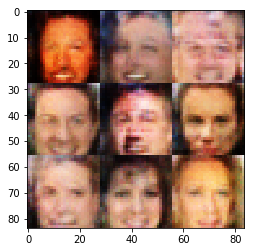

Epoch 1/1... Discriminator Loss: 2.9078... Generator Loss: 0.0947
Epoch 1/1... Discriminator Loss: 3.1921... Generator Loss: 0.0675
Epoch 1/1... Discriminator Loss: 3.0139... Generator Loss: 0.0831
Epoch 1/1... Discriminator Loss: 1.7940... Generator Loss: 0.3259
Epoch 1/1... Discriminator Loss: 2.3504... Generator Loss: 0.1872
Epoch 1/1... Discriminator Loss: 2.6508... Generator Loss: 0.1302
Epoch 1/1... Discriminator Loss: 1.6108... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 2.8281... Generator Loss: 0.0980
Epoch 1/1... Discriminator Loss: 2.4492... Generator Loss: 0.1489
Epoch 1/1... Discriminator Loss: 2.3914... Generator Loss: 0.1761


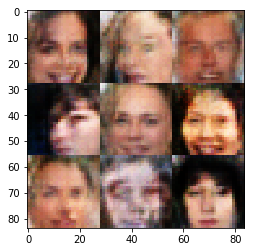

Epoch 1/1... Discriminator Loss: 2.5088... Generator Loss: 0.1441
Epoch 1/1... Discriminator Loss: 2.5695... Generator Loss: 0.1379
Epoch 1/1... Discriminator Loss: 2.4605... Generator Loss: 0.1428
Epoch 1/1... Discriminator Loss: 2.8510... Generator Loss: 0.1084
Epoch 1/1... Discriminator Loss: 2.1393... Generator Loss: 0.2108
Epoch 1/1... Discriminator Loss: 2.0527... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 2.1158... Generator Loss: 0.2339
Epoch 1/1... Discriminator Loss: 2.2421... Generator Loss: 0.2093
Epoch 1/1... Discriminator Loss: 2.4066... Generator Loss: 0.1765
Epoch 1/1... Discriminator Loss: 3.0435... Generator Loss: 0.0849


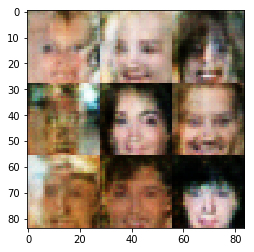

Epoch 1/1... Discriminator Loss: 2.9619... Generator Loss: 0.0939
Epoch 1/1... Discriminator Loss: 2.2132... Generator Loss: 0.2024
Epoch 1/1... Discriminator Loss: 2.5208... Generator Loss: 0.1557
Epoch 1/1... Discriminator Loss: 2.5095... Generator Loss: 0.1479
Epoch 1/1... Discriminator Loss: 2.7979... Generator Loss: 0.0986
Epoch 1/1... Discriminator Loss: 2.4978... Generator Loss: 0.1387
Epoch 1/1... Discriminator Loss: 2.5413... Generator Loss: 0.1241
Epoch 1/1... Discriminator Loss: 2.5938... Generator Loss: 0.1445
Epoch 1/1... Discriminator Loss: 2.2167... Generator Loss: 0.1833
Epoch 1/1... Discriminator Loss: 2.5025... Generator Loss: 0.1464


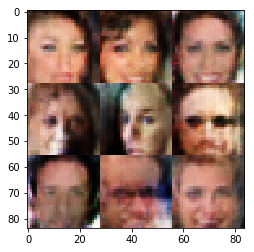

Epoch 1/1... Discriminator Loss: 2.5521... Generator Loss: 0.1412
Epoch 1/1... Discriminator Loss: 2.3547... Generator Loss: 0.1694
Epoch 1/1... Discriminator Loss: 1.9928... Generator Loss: 0.2410
Epoch 1/1... Discriminator Loss: 2.5109... Generator Loss: 0.1454
Epoch 1/1... Discriminator Loss: 2.6816... Generator Loss: 0.1098
Epoch 1/1... Discriminator Loss: 2.9090... Generator Loss: 0.0908
Epoch 1/1... Discriminator Loss: 2.7037... Generator Loss: 0.1077
Epoch 1/1... Discriminator Loss: 1.8465... Generator Loss: 0.3755
Epoch 1/1... Discriminator Loss: 2.1881... Generator Loss: 0.1876
Epoch 1/1... Discriminator Loss: 3.1938... Generator Loss: 0.0665


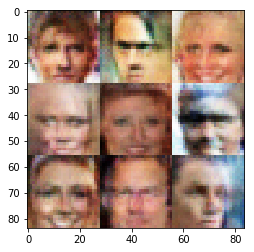

Epoch 1/1... Discriminator Loss: 2.9515... Generator Loss: 0.0795
Epoch 1/1... Discriminator Loss: 2.5469... Generator Loss: 0.1487
Epoch 1/1... Discriminator Loss: 2.5531... Generator Loss: 0.1338
Epoch 1/1... Discriminator Loss: 2.6481... Generator Loss: 0.1175
Epoch 1/1... Discriminator Loss: 2.8700... Generator Loss: 0.1183
Epoch 1/1... Discriminator Loss: 2.3337... Generator Loss: 0.1708
Epoch 1/1... Discriminator Loss: 2.4439... Generator Loss: 0.1886
Epoch 1/1... Discriminator Loss: 2.5798... Generator Loss: 0.1273
Epoch 1/1... Discriminator Loss: 2.3195... Generator Loss: 0.1629
Epoch 1/1... Discriminator Loss: 2.4461... Generator Loss: 0.1593


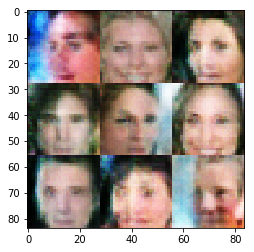

Epoch 1/1... Discriminator Loss: 2.5571... Generator Loss: 0.1360
Epoch 1/1... Discriminator Loss: 2.6573... Generator Loss: 0.1202
Epoch 1/1... Discriminator Loss: 2.6970... Generator Loss: 0.1231
Epoch 1/1... Discriminator Loss: 2.7323... Generator Loss: 0.1163
Epoch 1/1... Discriminator Loss: 2.4889... Generator Loss: 0.1428
Epoch 1/1... Discriminator Loss: 2.5437... Generator Loss: 0.1392
Epoch 1/1... Discriminator Loss: 1.7552... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 2.4652... Generator Loss: 0.1640
Epoch 1/1... Discriminator Loss: 2.7740... Generator Loss: 0.1150
Epoch 1/1... Discriminator Loss: 2.5010... Generator Loss: 0.1665


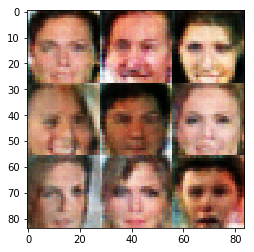

Epoch 1/1... Discriminator Loss: 2.3398... Generator Loss: 0.1755
Epoch 1/1... Discriminator Loss: 2.4915... Generator Loss: 0.1424
Epoch 1/1... Discriminator Loss: 2.2944... Generator Loss: 0.1834
Epoch 1/1... Discriminator Loss: 2.4564... Generator Loss: 0.1440
Epoch 1/1... Discriminator Loss: 2.2625... Generator Loss: 0.1939
Epoch 1/1... Discriminator Loss: 2.3697... Generator Loss: 0.1598
Epoch 1/1... Discriminator Loss: 2.4618... Generator Loss: 0.1573
Epoch 1/1... Discriminator Loss: 2.1709... Generator Loss: 0.2118
Epoch 1/1... Discriminator Loss: 2.0379... Generator Loss: 0.2199
Epoch 1/1... Discriminator Loss: 2.2512... Generator Loss: 0.1906


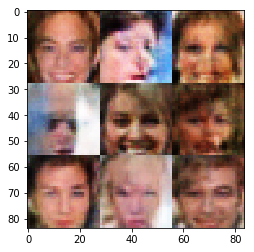

Epoch 1/1... Discriminator Loss: 1.8454... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 2.9438... Generator Loss: 0.1029
Epoch 1/1... Discriminator Loss: 3.0584... Generator Loss: 0.0826
Epoch 1/1... Discriminator Loss: 2.9999... Generator Loss: 0.0801
Epoch 1/1... Discriminator Loss: 2.6151... Generator Loss: 0.1261
Epoch 1/1... Discriminator Loss: 3.4193... Generator Loss: 0.0659
Epoch 1/1... Discriminator Loss: 2.5645... Generator Loss: 0.1391
Epoch 1/1... Discriminator Loss: 2.6103... Generator Loss: 0.1205
Epoch 1/1... Discriminator Loss: 1.9735... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 2.8489... Generator Loss: 0.1053


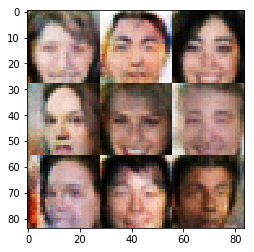

Epoch 1/1... Discriminator Loss: 2.1411... Generator Loss: 0.2402
Epoch 1/1... Discriminator Loss: 2.7911... Generator Loss: 0.1108
Epoch 1/1... Discriminator Loss: 2.6020... Generator Loss: 0.1226
Epoch 1/1... Discriminator Loss: 2.1103... Generator Loss: 0.2033
Epoch 1/1... Discriminator Loss: 2.0709... Generator Loss: 0.3050
Epoch 1/1... Discriminator Loss: 2.5792... Generator Loss: 0.1368
Epoch 1/1... Discriminator Loss: 2.8970... Generator Loss: 0.0887
Epoch 1/1... Discriminator Loss: 2.4959... Generator Loss: 0.1401
Epoch 1/1... Discriminator Loss: 2.3613... Generator Loss: 0.1704
Epoch 1/1... Discriminator Loss: 3.1285... Generator Loss: 0.0753


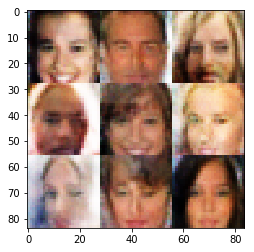

Epoch 1/1... Discriminator Loss: 2.5435... Generator Loss: 0.1392
Epoch 1/1... Discriminator Loss: 2.0451... Generator Loss: 0.2352
Epoch 1/1... Discriminator Loss: 2.4611... Generator Loss: 0.1427
Epoch 1/1... Discriminator Loss: 2.2372... Generator Loss: 0.1773
Epoch 1/1... Discriminator Loss: 2.8272... Generator Loss: 0.0976
Epoch 1/1... Discriminator Loss: 2.3363... Generator Loss: 0.1648
Epoch 1/1... Discriminator Loss: 2.4822... Generator Loss: 0.1422
Epoch 1/1... Discriminator Loss: 2.2356... Generator Loss: 0.1980
Epoch 1/1... Discriminator Loss: 1.9138... Generator Loss: 0.2927
Epoch 1/1... Discriminator Loss: 2.1272... Generator Loss: 0.2399


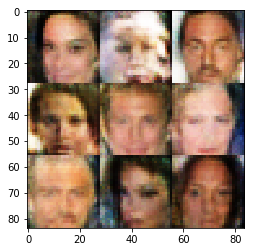

Epoch 1/1... Discriminator Loss: 2.0353... Generator Loss: 0.2324
Epoch 1/1... Discriminator Loss: 2.4505... Generator Loss: 0.1456
Epoch 1/1... Discriminator Loss: 3.1168... Generator Loss: 0.0831
Epoch 1/1... Discriminator Loss: 2.9893... Generator Loss: 0.0892
Epoch 1/1... Discriminator Loss: 2.7805... Generator Loss: 0.1032
Epoch 1/1... Discriminator Loss: 2.1646... Generator Loss: 0.2251
Epoch 1/1... Discriminator Loss: 1.8787... Generator Loss: 0.3030
Epoch 1/1... Discriminator Loss: 2.4214... Generator Loss: 0.1566
Epoch 1/1... Discriminator Loss: 3.0593... Generator Loss: 0.0765
Epoch 1/1... Discriminator Loss: 2.7998... Generator Loss: 0.1170


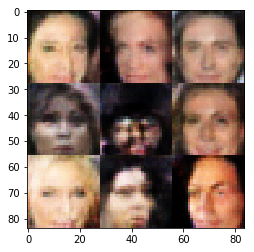

Epoch 1/1... Discriminator Loss: 2.4510... Generator Loss: 0.1519
Epoch 1/1... Discriminator Loss: 2.8181... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 2.5507... Generator Loss: 0.1355
Epoch 1/1... Discriminator Loss: 2.5210... Generator Loss: 0.1409
Epoch 1/1... Discriminator Loss: 2.5530... Generator Loss: 0.1273
Epoch 1/1... Discriminator Loss: 2.1529... Generator Loss: 0.2040
Epoch 1/1... Discriminator Loss: 2.7334... Generator Loss: 0.1038
Epoch 1/1... Discriminator Loss: 2.4300... Generator Loss: 0.1573
Epoch 1/1... Discriminator Loss: 2.8981... Generator Loss: 0.1078
Epoch 1/1... Discriminator Loss: 2.5868... Generator Loss: 0.1360


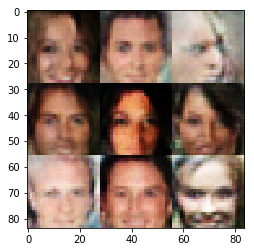

Epoch 1/1... Discriminator Loss: 2.3137... Generator Loss: 0.1683
Epoch 1/1... Discriminator Loss: 2.6167... Generator Loss: 0.1192
Epoch 1/1... Discriminator Loss: 2.2243... Generator Loss: 0.2173
Epoch 1/1... Discriminator Loss: 2.5686... Generator Loss: 0.1272
Epoch 1/1... Discriminator Loss: 2.5377... Generator Loss: 0.1311
Epoch 1/1... Discriminator Loss: 2.4356... Generator Loss: 0.1421
Epoch 1/1... Discriminator Loss: 2.9619... Generator Loss: 0.0847
Epoch 1/1... Discriminator Loss: 2.2319... Generator Loss: 0.2034
Epoch 1/1... Discriminator Loss: 3.1668... Generator Loss: 0.0669
Epoch 1/1... Discriminator Loss: 2.3848... Generator Loss: 0.1613


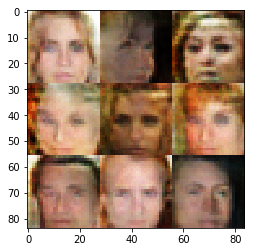

Epoch 1/1... Discriminator Loss: 2.4865... Generator Loss: 0.1563
Epoch 1/1... Discriminator Loss: 2.9138... Generator Loss: 0.1043
Epoch 1/1... Discriminator Loss: 2.6382... Generator Loss: 0.1221
Epoch 1/1... Discriminator Loss: 2.0852... Generator Loss: 0.2220
Epoch 1/1... Discriminator Loss: 2.6819... Generator Loss: 0.1074
Epoch 1/1... Discriminator Loss: 2.3104... Generator Loss: 0.1959
Epoch 1/1... Discriminator Loss: 2.6810... Generator Loss: 0.1155
Epoch 1/1... Discriminator Loss: 3.0197... Generator Loss: 0.0902
Epoch 1/1... Discriminator Loss: 2.8680... Generator Loss: 0.0888
Epoch 1/1... Discriminator Loss: 2.0299... Generator Loss: 0.2211


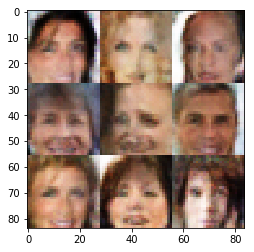

Epoch 1/1... Discriminator Loss: 2.4632... Generator Loss: 0.1498
Epoch 1/1... Discriminator Loss: 1.9757... Generator Loss: 0.2564
Epoch 1/1... Discriminator Loss: 2.1040... Generator Loss: 0.2225
Epoch 1/1... Discriminator Loss: 2.7998... Generator Loss: 0.1030
Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.3263
Epoch 1/1... Discriminator Loss: 2.6603... Generator Loss: 0.1215
Epoch 1/1... Discriminator Loss: 1.9466... Generator Loss: 0.2367
Epoch 1/1... Discriminator Loss: 2.4756... Generator Loss: 0.1754
Epoch 1/1... Discriminator Loss: 2.4336... Generator Loss: 0.2208
Epoch 1/1... Discriminator Loss: 2.1976... Generator Loss: 0.1922


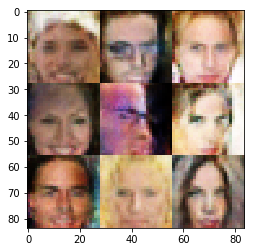

Epoch 1/1... Discriminator Loss: 3.2637... Generator Loss: 0.0746
Epoch 1/1... Discriminator Loss: 2.6413... Generator Loss: 0.1101
Epoch 1/1... Discriminator Loss: 2.6947... Generator Loss: 0.1046
Epoch 1/1... Discriminator Loss: 2.5236... Generator Loss: 0.1279
Epoch 1/1... Discriminator Loss: 2.3581... Generator Loss: 0.1600
Epoch 1/1... Discriminator Loss: 2.5512... Generator Loss: 0.1299
Epoch 1/1... Discriminator Loss: 3.0283... Generator Loss: 0.0924
Epoch 1/1... Discriminator Loss: 3.1732... Generator Loss: 0.0751
Epoch 1/1... Discriminator Loss: 2.3084... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 2.4796... Generator Loss: 0.1329


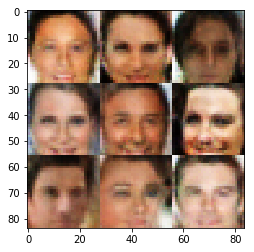

Epoch 1/1... Discriminator Loss: 3.0516... Generator Loss: 0.0760
Epoch 1/1... Discriminator Loss: 2.0901... Generator Loss: 0.2276
Epoch 1/1... Discriminator Loss: 4.2101... Generator Loss: 0.0277
Epoch 1/1... Discriminator Loss: 2.0815... Generator Loss: 0.2128
Epoch 1/1... Discriminator Loss: 2.4206... Generator Loss: 0.1441
Epoch 1/1... Discriminator Loss: 2.6976... Generator Loss: 0.1106
Epoch 1/1... Discriminator Loss: 2.0373... Generator Loss: 0.2200
Epoch 1/1... Discriminator Loss: 2.2642... Generator Loss: 0.1930
Epoch 1/1... Discriminator Loss: 2.6848... Generator Loss: 0.1097
Epoch 1/1... Discriminator Loss: 2.7999... Generator Loss: 0.1048


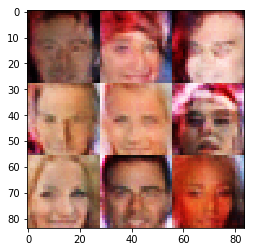

Epoch 1/1... Discriminator Loss: 2.9906... Generator Loss: 0.0804
Epoch 1/1... Discriminator Loss: 2.3030... Generator Loss: 0.1766
Epoch 1/1... Discriminator Loss: 2.8746... Generator Loss: 0.0899
Epoch 1/1... Discriminator Loss: 2.1246... Generator Loss: 0.2135
Epoch 1/1... Discriminator Loss: 2.1650... Generator Loss: 0.2116
Epoch 1/1... Discriminator Loss: 2.6263... Generator Loss: 0.1209
Epoch 1/1... Discriminator Loss: 1.9603... Generator Loss: 0.2737
Epoch 1/1... Discriminator Loss: 3.0950... Generator Loss: 0.0907
Epoch 1/1... Discriminator Loss: 3.0225... Generator Loss: 0.0786
Epoch 1/1... Discriminator Loss: 2.2031... Generator Loss: 0.1959


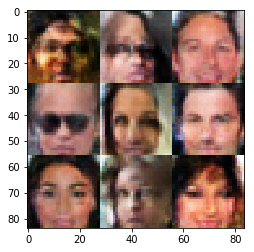

Epoch 1/1... Discriminator Loss: 2.5701... Generator Loss: 0.1288
Epoch 1/1... Discriminator Loss: 2.3629... Generator Loss: 0.1933
Epoch 1/1... Discriminator Loss: 2.2120... Generator Loss: 0.1861
Epoch 1/1... Discriminator Loss: 2.9654... Generator Loss: 0.0929
Epoch 1/1... Discriminator Loss: 1.7542... Generator Loss: 0.3364
Epoch 1/1... Discriminator Loss: 2.9336... Generator Loss: 0.0992
Epoch 1/1... Discriminator Loss: 2.6406... Generator Loss: 0.1388
Epoch 1/1... Discriminator Loss: 2.9737... Generator Loss: 0.0890
Epoch 1/1... Discriminator Loss: 2.8709... Generator Loss: 0.0972
Epoch 1/1... Discriminator Loss: 2.2678... Generator Loss: 0.1793


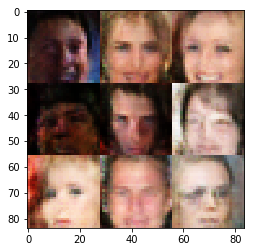

Epoch 1/1... Discriminator Loss: 2.9780... Generator Loss: 0.1009
Epoch 1/1... Discriminator Loss: 2.0665... Generator Loss: 0.2390
Epoch 1/1... Discriminator Loss: 2.0438... Generator Loss: 0.2191
Epoch 1/1... Discriminator Loss: 2.7177... Generator Loss: 0.1121
Epoch 1/1... Discriminator Loss: 2.4277... Generator Loss: 0.1568
Epoch 1/1... Discriminator Loss: 1.6345... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 2.2613... Generator Loss: 0.1829
Epoch 1/1... Discriminator Loss: 3.2157... Generator Loss: 0.0753
Epoch 1/1... Discriminator Loss: 2.7992... Generator Loss: 0.1084
Epoch 1/1... Discriminator Loss: 2.3734... Generator Loss: 0.1629


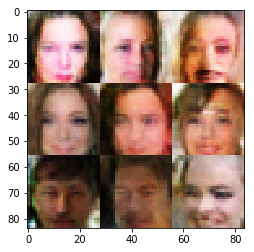

Epoch 1/1... Discriminator Loss: 3.4511... Generator Loss: 0.0556
Epoch 1/1... Discriminator Loss: 2.2170... Generator Loss: 0.1844
Epoch 1/1... Discriminator Loss: 2.5020... Generator Loss: 0.1698
Epoch 1/1... Discriminator Loss: 2.6869... Generator Loss: 0.1115
Epoch 1/1... Discriminator Loss: 1.9362... Generator Loss: 0.2661
Epoch 1/1... Discriminator Loss: 2.6507... Generator Loss: 0.1163
Epoch 1/1... Discriminator Loss: 2.3682... Generator Loss: 0.1717
Epoch 1/1... Discriminator Loss: 2.5516... Generator Loss: 0.1204
Epoch 1/1... Discriminator Loss: 2.9475... Generator Loss: 0.0861
Epoch 1/1... Discriminator Loss: 2.4452... Generator Loss: 0.1489


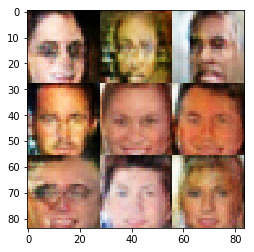

Epoch 1/1... Discriminator Loss: 2.9581... Generator Loss: 0.0847
Epoch 1/1... Discriminator Loss: 1.8468... Generator Loss: 0.2785
Epoch 1/1... Discriminator Loss: 3.0243... Generator Loss: 0.0791
Epoch 1/1... Discriminator Loss: 3.4324... Generator Loss: 0.0607
Epoch 1/1... Discriminator Loss: 2.2829... Generator Loss: 0.1792
Epoch 1/1... Discriminator Loss: 2.3985... Generator Loss: 0.1476
Epoch 1/1... Discriminator Loss: 2.2495... Generator Loss: 0.1878
Epoch 1/1... Discriminator Loss: 2.3036... Generator Loss: 0.1792
Epoch 1/1... Discriminator Loss: 3.2160... Generator Loss: 0.0695
Epoch 1/1... Discriminator Loss: 1.8955... Generator Loss: 0.2691


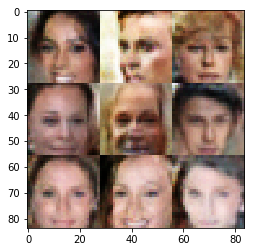

Epoch 1/1... Discriminator Loss: 2.6044... Generator Loss: 0.1265
Epoch 1/1... Discriminator Loss: 3.0665... Generator Loss: 0.0786
Epoch 1/1... Discriminator Loss: 2.9348... Generator Loss: 0.0890
Epoch 1/1... Discriminator Loss: 1.9761... Generator Loss: 0.2302
Epoch 1/1... Discriminator Loss: 2.3801... Generator Loss: 0.1739
Epoch 1/1... Discriminator Loss: 2.2160... Generator Loss: 0.1798
Epoch 1/1... Discriminator Loss: 2.5040... Generator Loss: 0.1432
Epoch 1/1... Discriminator Loss: 2.2316... Generator Loss: 0.1989
Epoch 1/1... Discriminator Loss: 3.2272... Generator Loss: 0.0720
Epoch 1/1... Discriminator Loss: 2.2185... Generator Loss: 0.1952


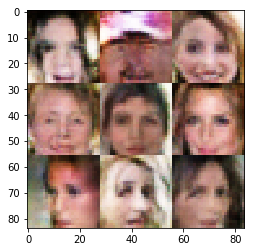

Epoch 1/1... Discriminator Loss: 2.8399... Generator Loss: 0.1159
Epoch 1/1... Discriminator Loss: 2.2120... Generator Loss: 0.1897
Epoch 1/1... Discriminator Loss: 3.0141... Generator Loss: 0.0866
Epoch 1/1... Discriminator Loss: 1.8318... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 2.6569... Generator Loss: 0.1153
Epoch 1/1... Discriminator Loss: 2.4081... Generator Loss: 0.1510
Epoch 1/1... Discriminator Loss: 2.2167... Generator Loss: 0.2190
Epoch 1/1... Discriminator Loss: 2.4660... Generator Loss: 0.1459
Epoch 1/1... Discriminator Loss: 2.5060... Generator Loss: 0.1503
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.4000


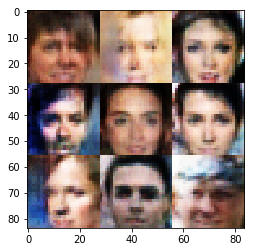

Epoch 1/1... Discriminator Loss: 2.7445... Generator Loss: 0.1105
Epoch 1/1... Discriminator Loss: 2.8686... Generator Loss: 0.0941
Epoch 1/1... Discriminator Loss: 4.2257... Generator Loss: 0.0266
Epoch 1/1... Discriminator Loss: 2.7671... Generator Loss: 0.1026
Epoch 1/1... Discriminator Loss: 2.5245... Generator Loss: 0.1546
Epoch 1/1... Discriminator Loss: 2.3419... Generator Loss: 0.2064
Epoch 1/1... Discriminator Loss: 2.8121... Generator Loss: 0.0979
Epoch 1/1... Discriminator Loss: 2.8405... Generator Loss: 0.0918
Epoch 1/1... Discriminator Loss: 2.0706... Generator Loss: 0.2140
Epoch 1/1... Discriminator Loss: 3.0257... Generator Loss: 0.0791


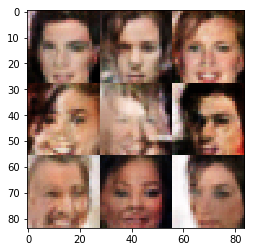

Epoch 1/1... Discriminator Loss: 2.8196... Generator Loss: 0.1134
Epoch 1/1... Discriminator Loss: 2.6820... Generator Loss: 0.1307
Epoch 1/1... Discriminator Loss: 2.4468... Generator Loss: 0.1469
Epoch 1/1... Discriminator Loss: 2.5030... Generator Loss: 0.1402
Epoch 1/1... Discriminator Loss: 2.4734... Generator Loss: 0.1501
Epoch 1/1... Discriminator Loss: 2.1990... Generator Loss: 0.1915
Epoch 1/1... Discriminator Loss: 2.4856... Generator Loss: 0.1427
Epoch 1/1... Discriminator Loss: 3.0223... Generator Loss: 0.0789
Epoch 1/1... Discriminator Loss: 3.0924... Generator Loss: 0.0847
Epoch 1/1... Discriminator Loss: 2.6616... Generator Loss: 0.1204


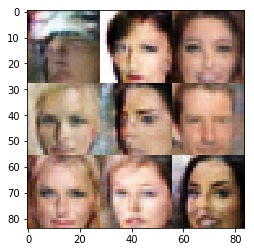

Epoch 1/1... Discriminator Loss: 3.4787... Generator Loss: 0.0494
Epoch 1/1... Discriminator Loss: 2.9638... Generator Loss: 0.0963
Epoch 1/1... Discriminator Loss: 3.3228... Generator Loss: 0.0716
Epoch 1/1... Discriminator Loss: 2.4806... Generator Loss: 0.1356
Epoch 1/1... Discriminator Loss: 2.4494... Generator Loss: 0.1440
Epoch 1/1... Discriminator Loss: 2.9358... Generator Loss: 0.0846
Epoch 1/1... Discriminator Loss: 2.4115... Generator Loss: 0.1620
Epoch 1/1... Discriminator Loss: 2.4858... Generator Loss: 0.1386
Epoch 1/1... Discriminator Loss: 2.7199... Generator Loss: 0.1142
Epoch 1/1... Discriminator Loss: 2.2985... Generator Loss: 0.1674


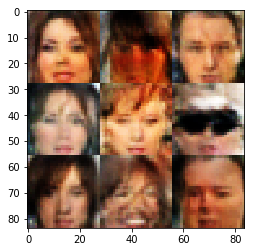

Epoch 1/1... Discriminator Loss: 2.1752... Generator Loss: 0.2148
Epoch 1/1... Discriminator Loss: 2.8682... Generator Loss: 0.0919
Epoch 1/1... Discriminator Loss: 3.1552... Generator Loss: 0.0722
Epoch 1/1... Discriminator Loss: 2.9749... Generator Loss: 0.0876
Epoch 1/1... Discriminator Loss: 2.4506... Generator Loss: 0.1538
Epoch 1/1... Discriminator Loss: 2.7376... Generator Loss: 0.1168
Epoch 1/1... Discriminator Loss: 2.4263... Generator Loss: 0.1556
Epoch 1/1... Discriminator Loss: 2.3065... Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 2.3840... Generator Loss: 0.1630
Epoch 1/1... Discriminator Loss: 2.4651... Generator Loss: 0.1496


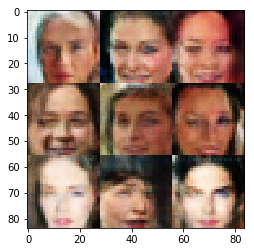

Epoch 1/1... Discriminator Loss: 2.3470... Generator Loss: 0.1570
Epoch 1/1... Discriminator Loss: 1.8403... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 2.7632... Generator Loss: 0.1187
Epoch 1/1... Discriminator Loss: 2.8378... Generator Loss: 0.1047
Epoch 1/1... Discriminator Loss: 2.5808... Generator Loss: 0.1452
Epoch 1/1... Discriminator Loss: 2.9778... Generator Loss: 0.0804
Epoch 1/1... Discriminator Loss: 2.4771... Generator Loss: 0.1568
Epoch 1/1... Discriminator Loss: 3.6477... Generator Loss: 0.0476
Epoch 1/1... Discriminator Loss: 3.1507... Generator Loss: 0.0646
Epoch 1/1... Discriminator Loss: 2.5179... Generator Loss: 0.1303


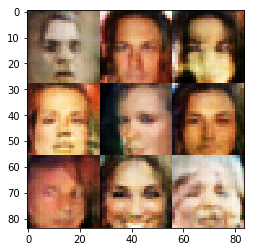

Epoch 1/1... Discriminator Loss: 2.2501... Generator Loss: 0.1964
Epoch 1/1... Discriminator Loss: 2.8231... Generator Loss: 0.0940
Epoch 1/1... Discriminator Loss: 3.1731... Generator Loss: 0.0770
Epoch 1/1... Discriminator Loss: 2.4787... Generator Loss: 0.1439
Epoch 1/1... Discriminator Loss: 3.1206... Generator Loss: 0.0770
Epoch 1/1... Discriminator Loss: 2.7396... Generator Loss: 0.1194
Epoch 1/1... Discriminator Loss: 2.1747... Generator Loss: 0.2091
Epoch 1/1... Discriminator Loss: 2.6799... Generator Loss: 0.1279
Epoch 1/1... Discriminator Loss: 2.8452... Generator Loss: 0.1016
Epoch 1/1... Discriminator Loss: 3.3989... Generator Loss: 0.0542


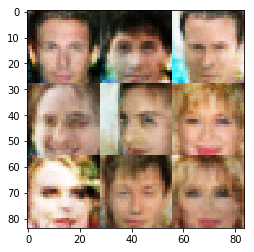

Epoch 1/1... Discriminator Loss: 2.2859... Generator Loss: 0.1848
Epoch 1/1... Discriminator Loss: 2.7045... Generator Loss: 0.1050
Epoch 1/1... Discriminator Loss: 2.3606... Generator Loss: 0.1639
Epoch 1/1... Discriminator Loss: 2.9123... Generator Loss: 0.0838
Epoch 1/1... Discriminator Loss: 3.2447... Generator Loss: 0.0604
Epoch 1/1... Discriminator Loss: 3.4265... Generator Loss: 0.0509
Epoch 1/1... Discriminator Loss: 2.3693... Generator Loss: 0.1563
Epoch 1/1... Discriminator Loss: 2.6324... Generator Loss: 0.1209
Epoch 1/1... Discriminator Loss: 2.8302... Generator Loss: 0.0995
Epoch 1/1... Discriminator Loss: 2.4741... Generator Loss: 0.1346


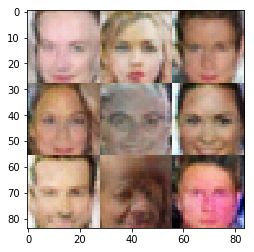

Epoch 1/1... Discriminator Loss: 1.8744... Generator Loss: 0.2624
Epoch 1/1... Discriminator Loss: 3.0055... Generator Loss: 0.0819
Epoch 1/1... Discriminator Loss: 2.6906... Generator Loss: 0.1142
Epoch 1/1... Discriminator Loss: 3.2161... Generator Loss: 0.0702
Epoch 1/1... Discriminator Loss: 2.6623... Generator Loss: 0.1198
Epoch 1/1... Discriminator Loss: 3.1785... Generator Loss: 0.0665
Epoch 1/1... Discriminator Loss: 3.0614... Generator Loss: 0.0781
Epoch 1/1... Discriminator Loss: 2.4318... Generator Loss: 0.1668
Epoch 1/1... Discriminator Loss: 2.0507... Generator Loss: 0.2319
Epoch 1/1... Discriminator Loss: 2.8113... Generator Loss: 0.1006


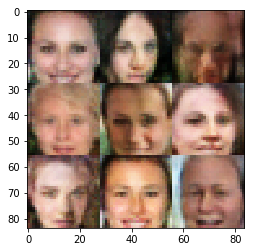

Epoch 1/1... Discriminator Loss: 2.6019... Generator Loss: 0.1213
Epoch 1/1... Discriminator Loss: 2.4935... Generator Loss: 0.1343
Epoch 1/1... Discriminator Loss: 3.4394... Generator Loss: 0.0532
Epoch 1/1... Discriminator Loss: 2.6397... Generator Loss: 0.1112
Epoch 1/1... Discriminator Loss: 2.5751... Generator Loss: 0.1281
Epoch 1/1... Discriminator Loss: 2.4957... Generator Loss: 0.1505
Epoch 1/1... Discriminator Loss: 2.3453... Generator Loss: 0.1604
Epoch 1/1... Discriminator Loss: 1.7878... Generator Loss: 0.3662
Epoch 1/1... Discriminator Loss: 2.5226... Generator Loss: 0.1321
Epoch 1/1... Discriminator Loss: 3.3449... Generator Loss: 0.0697


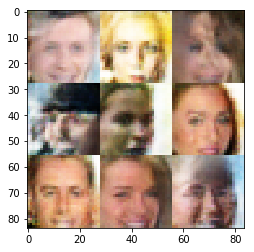

Epoch 1/1... Discriminator Loss: 2.0708... Generator Loss: 0.2331
Epoch 1/1... Discriminator Loss: 2.8249... Generator Loss: 0.0926
Epoch 1/1... Discriminator Loss: 2.4724... Generator Loss: 0.1566
Epoch 1/1... Discriminator Loss: 2.7164... Generator Loss: 0.1042
Epoch 1/1... Discriminator Loss: 3.4390... Generator Loss: 0.0537
Epoch 1/1... Discriminator Loss: 3.6643... Generator Loss: 0.0403
Epoch 1/1... Discriminator Loss: 2.5923... Generator Loss: 0.1371
Epoch 1/1... Discriminator Loss: 2.5554... Generator Loss: 0.1360
Epoch 1/1... Discriminator Loss: 2.8183... Generator Loss: 0.0955
Epoch 1/1... Discriminator Loss: 3.3288... Generator Loss: 0.0570


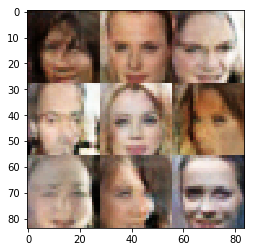

Epoch 1/1... Discriminator Loss: 2.1116... Generator Loss: 0.1977
Epoch 1/1... Discriminator Loss: 1.8553... Generator Loss: 0.2913
Epoch 1/1... Discriminator Loss: 2.2356... Generator Loss: 0.1780
Epoch 1/1... Discriminator Loss: 2.9644... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 3.4415... Generator Loss: 0.0564
Epoch 1/1... Discriminator Loss: 3.1079... Generator Loss: 0.0738
Epoch 1/1... Discriminator Loss: 3.0830... Generator Loss: 0.0895
Epoch 1/1... Discriminator Loss: 2.8451... Generator Loss: 0.0965
Epoch 1/1... Discriminator Loss: 2.6037... Generator Loss: 0.1242
Epoch 1/1... Discriminator Loss: 2.8753... Generator Loss: 0.1000


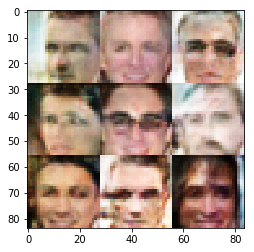

Epoch 1/1... Discriminator Loss: 2.3919... Generator Loss: 0.1651
Epoch 1/1... Discriminator Loss: 2.6993... Generator Loss: 0.1102
Epoch 1/1... Discriminator Loss: 2.1856... Generator Loss: 0.1876
Epoch 1/1... Discriminator Loss: 3.3093... Generator Loss: 0.0573
Epoch 1/1... Discriminator Loss: 2.9912... Generator Loss: 0.0866
Epoch 1/1... Discriminator Loss: 2.5113... Generator Loss: 0.1399
Epoch 1/1... Discriminator Loss: 2.3739... Generator Loss: 0.1529
Epoch 1/1... Discriminator Loss: 2.0580... Generator Loss: 0.2484
Epoch 1/1... Discriminator Loss: 2.8492... Generator Loss: 0.0987
Epoch 1/1... Discriminator Loss: 2.3072... Generator Loss: 0.1777


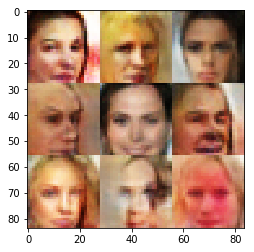

Epoch 1/1... Discriminator Loss: 2.6096... Generator Loss: 0.1430
Epoch 1/1... Discriminator Loss: 1.9648... Generator Loss: 0.2501
Epoch 1/1... Discriminator Loss: 3.6990... Generator Loss: 0.0423
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.3365
Epoch 1/1... Discriminator Loss: 3.2123... Generator Loss: 0.0631
Epoch 1/1... Discriminator Loss: 2.6340... Generator Loss: 0.1282
Epoch 1/1... Discriminator Loss: 3.9345... Generator Loss: 0.0345
Epoch 1/1... Discriminator Loss: 3.7334... Generator Loss: 0.0369
Epoch 1/1... Discriminator Loss: 2.3276... Generator Loss: 0.1592
Epoch 1/1... Discriminator Loss: 2.5439... Generator Loss: 0.1260


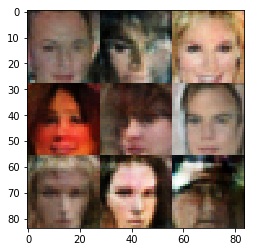

Epoch 1/1... Discriminator Loss: 2.5902... Generator Loss: 0.1185
Epoch 1/1... Discriminator Loss: 2.1219... Generator Loss: 0.2197
Epoch 1/1... Discriminator Loss: 2.8047... Generator Loss: 0.1013
Epoch 1/1... Discriminator Loss: 3.0574... Generator Loss: 0.0774
Epoch 1/1... Discriminator Loss: 1.8066... Generator Loss: 0.2987
Epoch 1/1... Discriminator Loss: 2.4042... Generator Loss: 0.1499
Epoch 1/1... Discriminator Loss: 2.4611... Generator Loss: 0.1353
Epoch 1/1... Discriminator Loss: 2.6492... Generator Loss: 0.1129
Epoch 1/1... Discriminator Loss: 3.6671... Generator Loss: 0.0421
Epoch 1/1... Discriminator Loss: 2.6256... Generator Loss: 0.1279


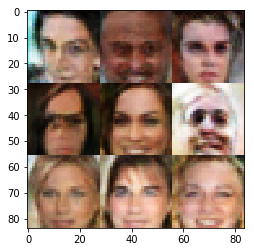

Epoch 1/1... Discriminator Loss: 3.5821... Generator Loss: 0.0467
Epoch 1/1... Discriminator Loss: 2.7953... Generator Loss: 0.0923
Epoch 1/1... Discriminator Loss: 2.5051... Generator Loss: 0.1369
Epoch 1/1... Discriminator Loss: 3.2267... Generator Loss: 0.0659
Epoch 1/1... Discriminator Loss: 3.2794... Generator Loss: 0.0665
Epoch 1/1... Discriminator Loss: 2.4816... Generator Loss: 0.1364
Epoch 1/1... Discriminator Loss: 2.3030... Generator Loss: 0.1825
Epoch 1/1... Discriminator Loss: 2.8475... Generator Loss: 0.0928
Epoch 1/1... Discriminator Loss: 3.0217... Generator Loss: 0.0778
Epoch 1/1... Discriminator Loss: 2.7215... Generator Loss: 0.1067


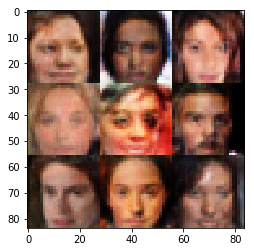

Epoch 1/1... Discriminator Loss: 1.8909... Generator Loss: 0.2990
Epoch 1/1... Discriminator Loss: 2.3785... Generator Loss: 0.1649
Epoch 1/1... Discriminator Loss: 2.3796... Generator Loss: 0.1523
Epoch 1/1... Discriminator Loss: 2.9348... Generator Loss: 0.0902
Epoch 1/1... Discriminator Loss: 3.0716... Generator Loss: 0.0796
Epoch 1/1... Discriminator Loss: 2.3902... Generator Loss: 0.1493
Epoch 1/1... Discriminator Loss: 3.4744... Generator Loss: 0.0495
Epoch 1/1... Discriminator Loss: 3.4675... Generator Loss: 0.0464
Epoch 1/1... Discriminator Loss: 2.6193... Generator Loss: 0.1175
Epoch 1/1... Discriminator Loss: 2.7802... Generator Loss: 0.0982


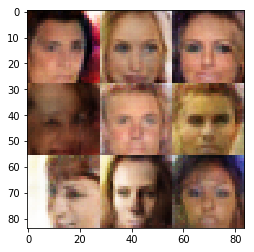

Epoch 1/1... Discriminator Loss: 2.5984... Generator Loss: 0.1257
Epoch 1/1... Discriminator Loss: 3.1839... Generator Loss: 0.0718
Epoch 1/1... Discriminator Loss: 2.3433... Generator Loss: 0.1631
Epoch 1/1... Discriminator Loss: 2.9193... Generator Loss: 0.0891
Epoch 1/1... Discriminator Loss: 3.0916... Generator Loss: 0.0689
Epoch 1/1... Discriminator Loss: 2.5622... Generator Loss: 0.1467
Epoch 1/1... Discriminator Loss: 3.1280... Generator Loss: 0.0742
Epoch 1/1... Discriminator Loss: 3.2224... Generator Loss: 0.0631
Epoch 1/1... Discriminator Loss: 2.6797... Generator Loss: 0.1067
Epoch 1/1... Discriminator Loss: 2.6306... Generator Loss: 0.1181


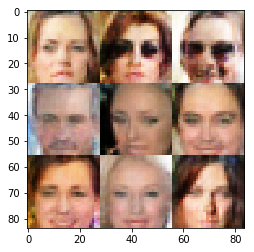

Epoch 1/1... Discriminator Loss: 2.8418... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 2.7753... Generator Loss: 0.1110
Epoch 1/1... Discriminator Loss: 3.3863... Generator Loss: 0.0552
Epoch 1/1... Discriminator Loss: 3.1359... Generator Loss: 0.0769
Epoch 1/1... Discriminator Loss: 2.8188... Generator Loss: 0.1023
Epoch 1/1... Discriminator Loss: 2.1137... Generator Loss: 0.2052
Epoch 1/1... Discriminator Loss: 2.5129... Generator Loss: 0.1473
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.3865
Epoch 1/1... Discriminator Loss: 3.2727... Generator Loss: 0.0657
Epoch 1/1... Discriminator Loss: 2.7979... Generator Loss: 0.1124


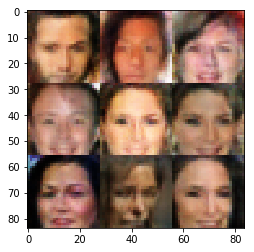

Epoch 1/1... Discriminator Loss: 2.5884... Generator Loss: 0.1268
Epoch 1/1... Discriminator Loss: 2.5925... Generator Loss: 0.1162
Epoch 1/1... Discriminator Loss: 2.9858... Generator Loss: 0.0761
Epoch 1/1... Discriminator Loss: 3.0226... Generator Loss: 0.0813
Epoch 1/1... Discriminator Loss: 2.8007... Generator Loss: 0.0999
Epoch 1/1... Discriminator Loss: 1.7837... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 3.5124... Generator Loss: 0.0456
Epoch 1/1... Discriminator Loss: 1.8916... Generator Loss: 0.3203
Epoch 1/1... Discriminator Loss: 3.1355... Generator Loss: 0.0731
Epoch 1/1... Discriminator Loss: 2.3151... Generator Loss: 0.1856


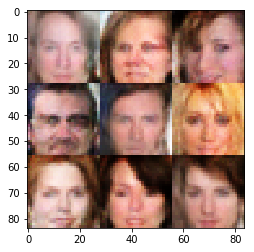

Epoch 1/1... Discriminator Loss: 2.6880... Generator Loss: 0.1062
Epoch 1/1... Discriminator Loss: 2.5709... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 2.4446... Generator Loss: 0.1711
Epoch 1/1... Discriminator Loss: 3.2023... Generator Loss: 0.0657
Epoch 1/1... Discriminator Loss: 3.1558... Generator Loss: 0.0671
Epoch 1/1... Discriminator Loss: 3.1132... Generator Loss: 0.0738
Epoch 1/1... Discriminator Loss: 3.6893... Generator Loss: 0.0446
Epoch 1/1... Discriminator Loss: 3.0268... Generator Loss: 0.0960
Epoch 1/1... Discriminator Loss: 3.3687... Generator Loss: 0.0520
Epoch 1/1... Discriminator Loss: 2.5482... Generator Loss: 0.1285


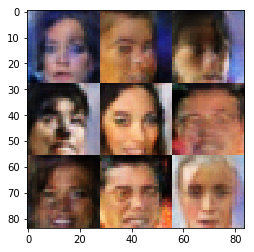

Epoch 1/1... Discriminator Loss: 3.1983... Generator Loss: 0.0628
Epoch 1/1... Discriminator Loss: 2.4299... Generator Loss: 0.1404
Epoch 1/1... Discriminator Loss: 2.9015... Generator Loss: 0.0856
Epoch 1/1... Discriminator Loss: 2.8291... Generator Loss: 0.0939
Epoch 1/1... Discriminator Loss: 2.6054... Generator Loss: 0.1231
Epoch 1/1... Discriminator Loss: 2.8691... Generator Loss: 0.1011
Epoch 1/1... Discriminator Loss: 3.1006... Generator Loss: 0.0705
Epoch 1/1... Discriminator Loss: 2.9049... Generator Loss: 0.0853
Epoch 1/1... Discriminator Loss: 2.3434... Generator Loss: 0.1591
Epoch 1/1... Discriminator Loss: 3.8702... Generator Loss: 0.0349


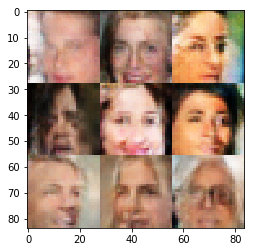

Epoch 1/1... Discriminator Loss: 3.0403... Generator Loss: 0.0912
Epoch 1/1... Discriminator Loss: 2.9124... Generator Loss: 0.0858
Epoch 1/1... Discriminator Loss: 2.8067... Generator Loss: 0.0952
Epoch 1/1... Discriminator Loss: 2.2326... Generator Loss: 0.2233
Epoch 1/1... Discriminator Loss: 2.8831... Generator Loss: 0.0883
Epoch 1/1... Discriminator Loss: 2.9562... Generator Loss: 0.0923
Epoch 1/1... Discriminator Loss: 2.8306... Generator Loss: 0.0962
Epoch 1/1... Discriminator Loss: 3.2054... Generator Loss: 0.0748
Epoch 1/1... Discriminator Loss: 2.2389... Generator Loss: 0.2017
Epoch 1/1... Discriminator Loss: 2.3175... Generator Loss: 0.1829


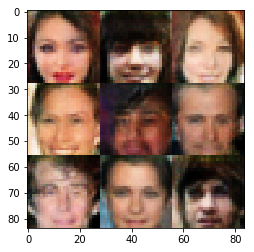

Epoch 1/1... Discriminator Loss: 2.9251... Generator Loss: 0.1107
Epoch 1/1... Discriminator Loss: 3.2813... Generator Loss: 0.0664
Epoch 1/1... Discriminator Loss: 2.1368... Generator Loss: 0.1925
Epoch 1/1... Discriminator Loss: 2.7877... Generator Loss: 0.1107
Epoch 1/1... Discriminator Loss: 1.9081... Generator Loss: 0.2567
Epoch 1/1... Discriminator Loss: 2.6125... Generator Loss: 0.1275
Epoch 1/1... Discriminator Loss: 1.9421... Generator Loss: 0.2489
Epoch 1/1... Discriminator Loss: 2.2617... Generator Loss: 0.1920
Epoch 1/1... Discriminator Loss: 2.9206... Generator Loss: 0.0902
Epoch 1/1... Discriminator Loss: 3.0711... Generator Loss: 0.0868


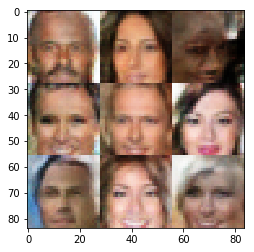

Epoch 1/1... Discriminator Loss: 2.3893... Generator Loss: 0.1435
Epoch 1/1... Discriminator Loss: 3.2955... Generator Loss: 0.0585
Epoch 1/1... Discriminator Loss: 2.3609... Generator Loss: 0.1659
Epoch 1/1... Discriminator Loss: 3.0095... Generator Loss: 0.0793
Epoch 1/1... Discriminator Loss: 2.6517... Generator Loss: 0.1176
Epoch 1/1... Discriminator Loss: 2.8590... Generator Loss: 0.0897
Epoch 1/1... Discriminator Loss: 3.4861... Generator Loss: 0.0471
Epoch 1/1... Discriminator Loss: 3.1828... Generator Loss: 0.0649
Epoch 1/1... Discriminator Loss: 3.5446... Generator Loss: 0.0684
Epoch 1/1... Discriminator Loss: 2.8031... Generator Loss: 0.0975


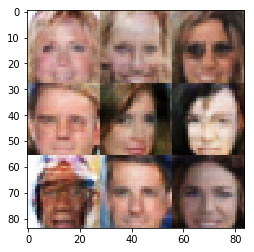

Epoch 1/1... Discriminator Loss: 2.6139... Generator Loss: 0.1312
Epoch 1/1... Discriminator Loss: 3.3775... Generator Loss: 0.0615
Epoch 1/1... Discriminator Loss: 3.0012... Generator Loss: 0.0754
Epoch 1/1... Discriminator Loss: 1.8135... Generator Loss: 0.2785
Epoch 1/1... Discriminator Loss: 2.3354... Generator Loss: 0.1612
Epoch 1/1... Discriminator Loss: 2.5343... Generator Loss: 0.1261
Epoch 1/1... Discriminator Loss: 2.7456... Generator Loss: 0.0997
Epoch 1/1... Discriminator Loss: 4.4691... Generator Loss: 0.0181
Epoch 1/1... Discriminator Loss: 2.4782... Generator Loss: 0.1484
Epoch 1/1... Discriminator Loss: 2.6718... Generator Loss: 0.1201


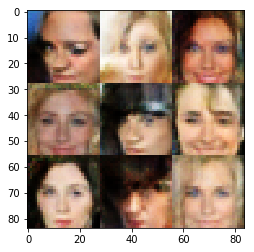

Epoch 1/1... Discriminator Loss: 3.2222... Generator Loss: 0.0653
Epoch 1/1... Discriminator Loss: 3.6140... Generator Loss: 0.0474
Epoch 1/1... Discriminator Loss: 3.3323... Generator Loss: 0.0589
Epoch 1/1... Discriminator Loss: 3.6339... Generator Loss: 0.0524
Epoch 1/1... Discriminator Loss: 2.9360... Generator Loss: 0.0902
Epoch 1/1... Discriminator Loss: 2.8734... Generator Loss: 0.0936
Epoch 1/1... Discriminator Loss: 3.5987... Generator Loss: 0.0438
Epoch 1/1... Discriminator Loss: 2.7430... Generator Loss: 0.1173
Epoch 1/1... Discriminator Loss: 2.6750... Generator Loss: 0.1250
Epoch 1/1... Discriminator Loss: 3.5228... Generator Loss: 0.0498


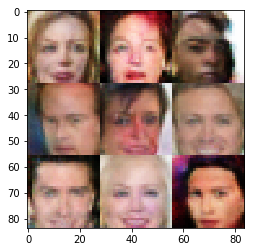

Epoch 1/1... Discriminator Loss: 3.6025... Generator Loss: 0.0485
Epoch 1/1... Discriminator Loss: 3.2703... Generator Loss: 0.0676
Epoch 1/1... Discriminator Loss: 2.6417... Generator Loss: 0.1101
Epoch 1/1... Discriminator Loss: 2.2339... Generator Loss: 0.1797
Epoch 1/1... Discriminator Loss: 3.3765... Generator Loss: 0.0587
Epoch 1/1... Discriminator Loss: 3.2423... Generator Loss: 0.0622
Epoch 1/1... Discriminator Loss: 2.8598... Generator Loss: 0.1117
Epoch 1/1... Discriminator Loss: 2.3078... Generator Loss: 0.1714
Epoch 1/1... Discriminator Loss: 2.3553... Generator Loss: 0.2165
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.3101


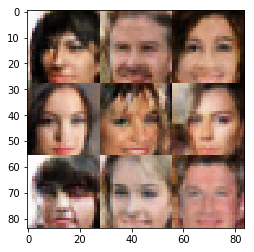

Epoch 1/1... Discriminator Loss: 2.4223... Generator Loss: 0.1474
Epoch 1/1... Discriminator Loss: 3.0137... Generator Loss: 0.0781
Epoch 1/1... Discriminator Loss: 2.8228... Generator Loss: 0.1046
Epoch 1/1... Discriminator Loss: 3.1792... Generator Loss: 0.0654
Epoch 1/1... Discriminator Loss: 2.7990... Generator Loss: 0.1028
Epoch 1/1... Discriminator Loss: 2.7089... Generator Loss: 0.1162
Epoch 1/1... Discriminator Loss: 4.2670... Generator Loss: 0.0248
Epoch 1/1... Discriminator Loss: 3.7087... Generator Loss: 0.0384
Epoch 1/1... Discriminator Loss: 2.3008... Generator Loss: 0.1680
Epoch 1/1... Discriminator Loss: 2.7093... Generator Loss: 0.1172


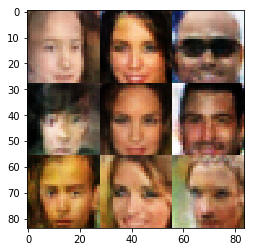

Epoch 1/1... Discriminator Loss: 2.9873... Generator Loss: 0.0804
Epoch 1/1... Discriminator Loss: 3.1064... Generator Loss: 0.0752
Epoch 1/1... Discriminator Loss: 2.6550... Generator Loss: 0.1270


In [15]:
batch_size = 16
z_dim = 256
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,celeba_dataset.shape, celeba_dataset.image_mode)

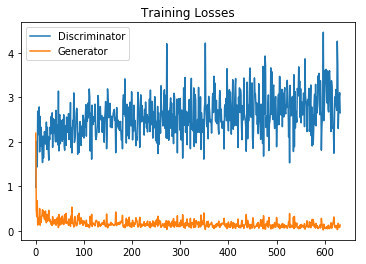

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

Here i tried to make k optimization steps in the descriminator like the paper as i undestand that the descriminator loss should be around 0.5 so that it can't tell if an image fake or not fake and so also the generator loss, as half the time the descriminator will tell that the generator output is fake. also i readed that the generator loss shouldn't decrease over time but the decriminator loss should decrease.but in the coming cells the descriminator loss desn't decrease over time it oscilate

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,alpha=0.1,print_every=20,show_every=200):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real,input_z,lr=model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss=model_loss(input_real, input_z, data_shape[3])
    d_optimizer,g_optimizer=model_opt(d_loss, g_loss, lr, beta1)
    
    saver=tf.train.Saver()
    sample_z=np.random.uniform(-1,1,size=(10,z_dim))
    samples,losses=[],[]
    steps=0
    
 
    with tf.Session() as sess:
        k=0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #scale the image value to be between -1 ,1
                batch_images=batch_images*2
                # TODO: Train Model
                steps+=1
                #sample random noise for G
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                #run optimizer
                if(k !=3):
                    _=sess.run(d_optimizer,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                    k+=1
                if(k==3):
                    _=sess.run(g_optimizer,feed_dict={input_z:batch_z,input_real:batch_images,lr:learning_rate})
                    _=sess.run(g_optimizer,feed_dict={input_z:batch_z,input_real:batch_images,lr:learning_rate})
                    k=0

                    
                if steps % print_every==0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d,train_loss_g))
                if steps%show_every==0:
                    show_generator_output(sess, 10, input_z, batch_images.shape[3], data_image_mode)
        saver.save(sess,'./checkpoints/generator.ckpt')
    return losses

Epoch 1/2... Discriminator Loss: 0.3434... Generator Loss: 6.1408
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 11.4950
Epoch 1/2... Discriminator Loss: 2.4129... Generator Loss: 0.1466
Epoch 1/2... Discriminator Loss: 0.3816... Generator Loss: 5.2024
Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 4.2324
Epoch 1/2... Discriminator Loss: 1.9794... Generator Loss: 0.2547
Epoch 1/2... Discriminator Loss: 0.4649... Generator Loss: 3.8959
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 3.9674
Epoch 1/2... Discriminator Loss: 2.6853... Generator Loss: 0.1097
Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 4.3341


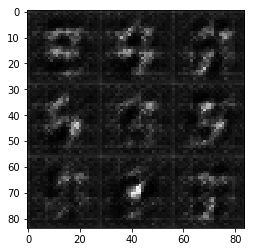

Epoch 1/2... Discriminator Loss: 0.4616... Generator Loss: 2.9145
Epoch 1/2... Discriminator Loss: 2.2916... Generator Loss: 0.1800
Epoch 1/2... Discriminator Loss: 0.4445... Generator Loss: 2.5698
Epoch 1/2... Discriminator Loss: 0.4623... Generator Loss: 2.3772
Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.4533
Epoch 1/2... Discriminator Loss: 1.8797... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 0.5593... Generator Loss: 1.9187
Epoch 1/2... Discriminator Loss: 2.0392... Generator Loss: 0.2671
Epoch 1/2... Discriminator Loss: 0.4066... Generator Loss: 3.0864
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 3.8544


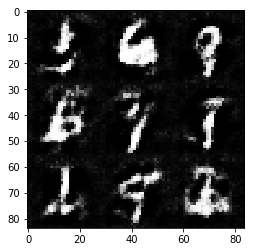

Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 2.2159
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 4.7717
Epoch 1/2... Discriminator Loss: 2.1045... Generator Loss: 0.2194
Epoch 1/2... Discriminator Loss: 0.4298... Generator Loss: 3.3748
Epoch 1/2... Discriminator Loss: 0.5037... Generator Loss: 3.9406
Epoch 1/2... Discriminator Loss: 2.2048... Generator Loss: 0.1931
Epoch 1/2... Discriminator Loss: 0.3502... Generator Loss: 4.3617
Epoch 1/2... Discriminator Loss: 0.4367... Generator Loss: 4.6170
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.6802


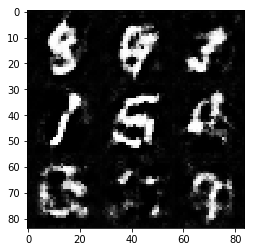

Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 1.6708
Epoch 1/2... Discriminator Loss: 0.9132... Generator Loss: 1.3274
Epoch 1/2... Discriminator Loss: 1.6774... Generator Loss: 0.3838
Epoch 1/2... Discriminator Loss: 0.3571... Generator Loss: 3.9412
Epoch 1/2... Discriminator Loss: 0.3667... Generator Loss: 3.7492
Epoch 1/2... Discriminator Loss: 2.4895... Generator Loss: 0.1482
Epoch 1/2... Discriminator Loss: 0.3544... Generator Loss: 4.8485
Epoch 1/2... Discriminator Loss: 0.4368... Generator Loss: 3.7643
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.5510
Epoch 1/2... Discriminator Loss: 0.3595... Generator Loss: 4.2376


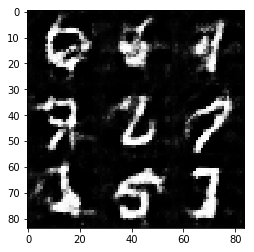

Epoch 1/2... Discriminator Loss: 0.3794... Generator Loss: 4.7821
Epoch 1/2... Discriminator Loss: 2.6486... Generator Loss: 0.1326
Epoch 1/2... Discriminator Loss: 0.3472... Generator Loss: 4.7352
Epoch 1/2... Discriminator Loss: 0.3529... Generator Loss: 3.9396
Epoch 1/2... Discriminator Loss: 2.4014... Generator Loss: 0.1552
Epoch 1/2... Discriminator Loss: 0.3549... Generator Loss: 4.3724
Epoch 1/2... Discriminator Loss: 0.4464... Generator Loss: 2.8093
Epoch 1/2... Discriminator Loss: 2.4192... Generator Loss: 0.1600
Epoch 1/2... Discriminator Loss: 0.3618... Generator Loss: 4.4662
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 3.1864


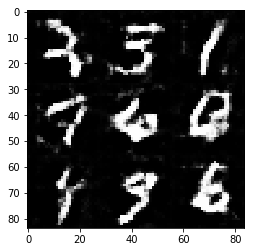

Epoch 1/2... Discriminator Loss: 2.2509... Generator Loss: 0.1862
Epoch 1/2... Discriminator Loss: 0.3724... Generator Loss: 3.3104
Epoch 1/2... Discriminator Loss: 0.3719... Generator Loss: 3.4508
Epoch 1/2... Discriminator Loss: 2.0086... Generator Loss: 0.2767
Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 4.8508
Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 4.2858
Epoch 1/2... Discriminator Loss: 2.9845... Generator Loss: 0.0868
Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 4.1332
Epoch 1/2... Discriminator Loss: 0.3524... Generator Loss: 5.2174
Epoch 1/2... Discriminator Loss: 1.4978... Generator Loss: 0.4498


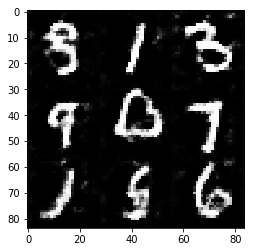

Epoch 1/2... Discriminator Loss: 0.3815... Generator Loss: 3.3673
Epoch 1/2... Discriminator Loss: 0.3622... Generator Loss: 4.2350
Epoch 1/2... Discriminator Loss: 2.8067... Generator Loss: 0.1027
Epoch 1/2... Discriminator Loss: 0.3775... Generator Loss: 3.3517
Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 2.4713
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 0.3973
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 3.9757
Epoch 1/2... Discriminator Loss: 0.5496... Generator Loss: 2.1854
Epoch 1/2... Discriminator Loss: 2.6696... Generator Loss: 0.1201
Epoch 1/2... Discriminator Loss: 0.3778... Generator Loss: 3.2852


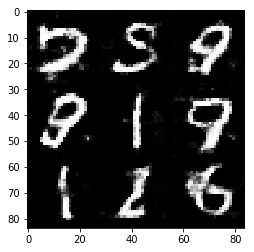

Epoch 1/2... Discriminator Loss: 0.4110... Generator Loss: 4.9399
Epoch 1/2... Discriminator Loss: 1.5349... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 0.3653... Generator Loss: 3.5333
Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 4.7824
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 0.3672... Generator Loss: 4.4960
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 2.3581
Epoch 1/2... Discriminator Loss: 2.6405... Generator Loss: 0.1180
Epoch 1/2... Discriminator Loss: 0.3658... Generator Loss: 6.4509
Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 2.1676


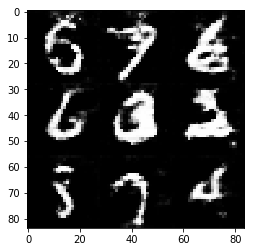

Epoch 1/2... Discriminator Loss: 2.1195... Generator Loss: 0.2155
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 5.4728
Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 5.3299
Epoch 1/2... Discriminator Loss: 2.2233... Generator Loss: 0.2315
Epoch 1/2... Discriminator Loss: 0.3395... Generator Loss: 5.5159
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 4.3730
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 0.3505... Generator Loss: 4.2631
Epoch 1/2... Discriminator Loss: 0.3629... Generator Loss: 4.1013
Epoch 1/2... Discriminator Loss: 1.8156... Generator Loss: 0.2935


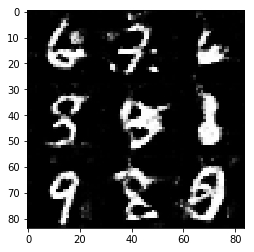

Epoch 1/2... Discriminator Loss: 0.3816... Generator Loss: 3.8466
Epoch 1/2... Discriminator Loss: 0.3502... Generator Loss: 4.0753
Epoch 1/2... Discriminator Loss: 2.4148... Generator Loss: 0.1473
Epoch 2/2... Discriminator Loss: 0.3378... Generator Loss: 5.6326
Epoch 2/2... Discriminator Loss: 0.3452... Generator Loss: 4.5346
Epoch 2/2... Discriminator Loss: 2.2493... Generator Loss: 0.1949
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 2.6891
Epoch 2/2... Discriminator Loss: 0.3492... Generator Loss: 4.6287
Epoch 2/2... Discriminator Loss: 2.3989... Generator Loss: 0.1589
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 2.2843


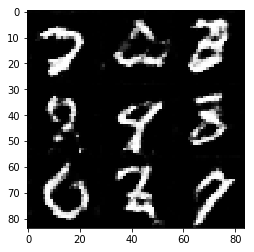

Epoch 2/2... Discriminator Loss: 0.3614... Generator Loss: 3.6329
Epoch 2/2... Discriminator Loss: 2.3231... Generator Loss: 0.1766
Epoch 2/2... Discriminator Loss: 0.3477... Generator Loss: 4.2884
Epoch 2/2... Discriminator Loss: 0.3433... Generator Loss: 6.9353
Epoch 2/2... Discriminator Loss: 1.6678... Generator Loss: 0.3706
Epoch 2/2... Discriminator Loss: 0.3373... Generator Loss: 4.8227
Epoch 2/2... Discriminator Loss: 0.3448... Generator Loss: 4.8208
Epoch 2/2... Discriminator Loss: 2.2097... Generator Loss: 0.1908
Epoch 2/2... Discriminator Loss: 0.3536... Generator Loss: 4.0627
Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 3.8966


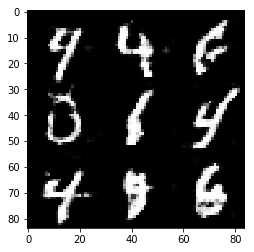

Epoch 2/2... Discriminator Loss: 2.1204... Generator Loss: 0.2109
Epoch 2/2... Discriminator Loss: 0.3586... Generator Loss: 4.1940
Epoch 2/2... Discriminator Loss: 0.3653... Generator Loss: 4.6805
Epoch 2/2... Discriminator Loss: 3.5806... Generator Loss: 0.0584
Epoch 2/2... Discriminator Loss: 0.3502... Generator Loss: 4.0954
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 1.2695
Epoch 2/2... Discriminator Loss: 2.2092... Generator Loss: 0.1828
Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 1.3488
Epoch 2/2... Discriminator Loss: 0.4419... Generator Loss: 4.7220
Epoch 2/2... Discriminator Loss: 1.7859... Generator Loss: 0.3340


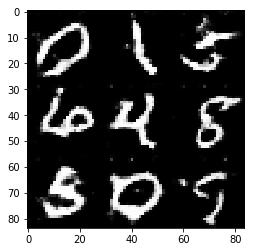

Epoch 2/2... Discriminator Loss: 0.3457... Generator Loss: 4.7008
Epoch 2/2... Discriminator Loss: 0.3384... Generator Loss: 5.1252
Epoch 2/2... Discriminator Loss: 1.9898... Generator Loss: 0.2673
Epoch 2/2... Discriminator Loss: 0.3317... Generator Loss: 6.9558
Epoch 2/2... Discriminator Loss: 0.3990... Generator Loss: 3.0908
Epoch 2/2... Discriminator Loss: 2.8656... Generator Loss: 0.0965
Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 3.2365
Epoch 2/2... Discriminator Loss: 0.3620... Generator Loss: 3.6348
Epoch 2/2... Discriminator Loss: 2.3551... Generator Loss: 0.1711
Epoch 2/2... Discriminator Loss: 0.3383... Generator Loss: 4.9599


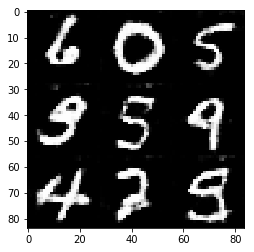

Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 2.7717
Epoch 2/2... Discriminator Loss: 2.0546... Generator Loss: 0.2132
Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 5.3089
Epoch 2/2... Discriminator Loss: 0.3393... Generator Loss: 4.7246
Epoch 2/2... Discriminator Loss: 2.3455... Generator Loss: 0.1670
Epoch 2/2... Discriminator Loss: 0.3601... Generator Loss: 5.2153
Epoch 2/2... Discriminator Loss: 0.3560... Generator Loss: 4.7507
Epoch 2/2... Discriminator Loss: 2.5046... Generator Loss: 0.1545
Epoch 2/2... Discriminator Loss: 0.3455... Generator Loss: 4.6670
Epoch 2/2... Discriminator Loss: 0.4147... Generator Loss: 2.7337


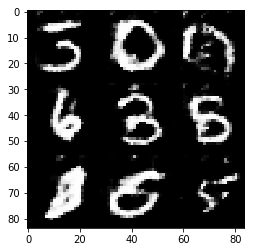

Epoch 2/2... Discriminator Loss: 2.5981... Generator Loss: 0.1373
Epoch 2/2... Discriminator Loss: 0.3448... Generator Loss: 6.7091
Epoch 2/2... Discriminator Loss: 0.3828... Generator Loss: 4.4972
Epoch 2/2... Discriminator Loss: 2.7709... Generator Loss: 0.1303
Epoch 2/2... Discriminator Loss: 0.3813... Generator Loss: 3.3751
Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 4.2452
Epoch 2/2... Discriminator Loss: 2.3358... Generator Loss: 0.1705
Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 4.3813
Epoch 2/2... Discriminator Loss: 0.3581... Generator Loss: 4.6253
Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 1.2040


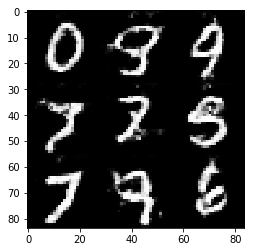

Epoch 2/2... Discriminator Loss: 0.4590... Generator Loss: 5.4153
Epoch 2/2... Discriminator Loss: 0.5817... Generator Loss: 6.4173
Epoch 2/2... Discriminator Loss: 2.4228... Generator Loss: 0.1461
Epoch 2/2... Discriminator Loss: 0.3456... Generator Loss: 5.5679
Epoch 2/2... Discriminator Loss: 0.3630... Generator Loss: 3.7827
Epoch 2/2... Discriminator Loss: 1.9852... Generator Loss: 0.2614
Epoch 2/2... Discriminator Loss: 0.3669... Generator Loss: 3.6506
Epoch 2/2... Discriminator Loss: 0.3470... Generator Loss: 4.2786
Epoch 2/2... Discriminator Loss: 2.5103... Generator Loss: 0.1353
Epoch 2/2... Discriminator Loss: 0.3299... Generator Loss: 6.6463


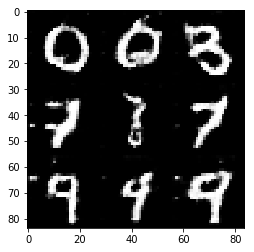

Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 5.3085
Epoch 2/2... Discriminator Loss: 3.2321... Generator Loss: 0.0814
Epoch 2/2... Discriminator Loss: 0.3387... Generator Loss: 5.4364
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 4.2073
Epoch 2/2... Discriminator Loss: 1.7109... Generator Loss: 0.3263
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 5.0961
Epoch 2/2... Discriminator Loss: 0.3529... Generator Loss: 4.1749
Epoch 2/2... Discriminator Loss: 1.6825... Generator Loss: 0.3317
Epoch 2/2... Discriminator Loss: 0.3389... Generator Loss: 5.2204
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 3.9281


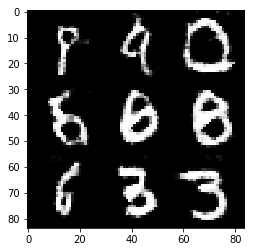

Epoch 2/2... Discriminator Loss: 2.3670... Generator Loss: 0.1624
Epoch 2/2... Discriminator Loss: 0.3381... Generator Loss: 5.7166
Epoch 2/2... Discriminator Loss: 0.3708... Generator Loss: 3.7415
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 0.3318... Generator Loss: 5.6810
Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 5.5650
Epoch 2/2... Discriminator Loss: 1.6553... Generator Loss: 0.3536
Epoch 2/2... Discriminator Loss: 0.3853... Generator Loss: 5.8134
Epoch 2/2... Discriminator Loss: 0.3678... Generator Loss: 4.5343
Epoch 2/2... Discriminator Loss: 2.3326... Generator Loss: 0.1783


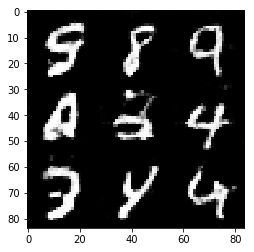

Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 4.9732
Epoch 2/2... Discriminator Loss: 0.3384... Generator Loss: 4.8605
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 0.4118... Generator Loss: 4.1434
Epoch 2/2... Discriminator Loss: 0.3414... Generator Loss: 5.5472
Epoch 2/2... Discriminator Loss: 1.5857... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 0.4111... Generator Loss: 5.7134


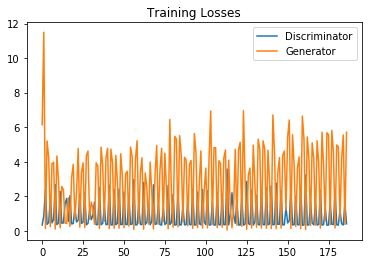

In [18]:
import numpy as np
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()    

Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 5.4109
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 4.5406
Epoch 1/1... Discriminator Loss: 3.7270... Generator Loss: 0.0386
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 5.0894
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 6.1267
Epoch 1/1... Discriminator Loss: 2.2898... Generator Loss: 0.2212
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 5.5258
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 3.7344
Epoch 1/1... Discriminator Loss: 2.4543... Generator Loss: 0.1503
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 3.7793


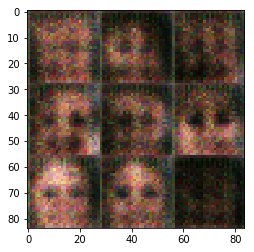

Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 5.4720
Epoch 1/1... Discriminator Loss: 3.8549... Generator Loss: 0.0382
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 5.1934
Epoch 1/1... Discriminator Loss: 0.3587... Generator Loss: 4.7917
Epoch 1/1... Discriminator Loss: 2.6941... Generator Loss: 0.1113
Epoch 1/1... Discriminator Loss: 0.3391... Generator Loss: 6.3110
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 3.4161... Generator Loss: 0.0673
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 4.4137
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 5.1163


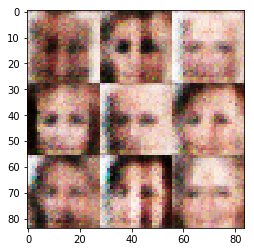

Epoch 1/1... Discriminator Loss: 3.9723... Generator Loss: 0.0386
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 3.5051
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 5.0912
Epoch 1/1... Discriminator Loss: 3.4270... Generator Loss: 0.0514
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 4.8330
Epoch 1/1... Discriminator Loss: 3.9183... Generator Loss: 0.0310
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 4.0501
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 2.8052
Epoch 1/1... Discriminator Loss: 3.8752... Generator Loss: 0.0357


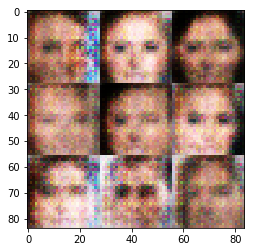

Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 3.0979
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 4.5490
Epoch 1/1... Discriminator Loss: 4.6294... Generator Loss: 0.0223
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 3.7021
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 4.4261
Epoch 1/1... Discriminator Loss: 4.5846... Generator Loss: 0.0202
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 4.9501
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 2.9835
Epoch 1/1... Discriminator Loss: 3.5837... Generator Loss: 0.0464
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 4.5227


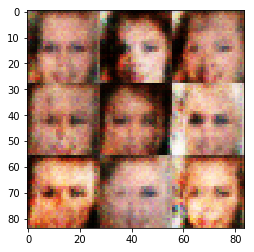

Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 6.7176
Epoch 1/1... Discriminator Loss: 3.7345... Generator Loss: 0.0373
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 4.0938
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 6.4128
Epoch 1/1... Discriminator Loss: 4.3087... Generator Loss: 0.0243
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 5.0904
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 5.6011
Epoch 1/1... Discriminator Loss: 2.8254... Generator Loss: 0.1211
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 4.8839
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 7.7276


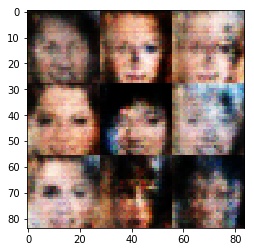

Epoch 1/1... Discriminator Loss: 4.1577... Generator Loss: 0.0251
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 6.2475
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 6.0383
Epoch 1/1... Discriminator Loss: 3.8863... Generator Loss: 0.0361
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 5.3055
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 4.8748
Epoch 1/1... Discriminator Loss: 4.9813... Generator Loss: 0.0126
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 6.6867
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 3.8997
Epoch 1/1... Discriminator Loss: 3.7886... Generator Loss: 0.0384


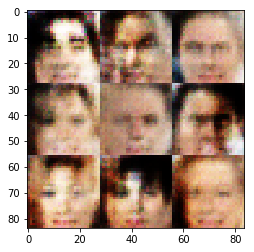

Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 3.7032
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 6.3820
Epoch 1/1... Discriminator Loss: 4.0933... Generator Loss: 0.0275
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 5.8602
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 3.4961
Epoch 1/1... Discriminator Loss: 3.5393... Generator Loss: 0.0452
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.2211
Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 3.5327
Epoch 1/1... Discriminator Loss: 4.8099... Generator Loss: 0.0194
Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 6.2579


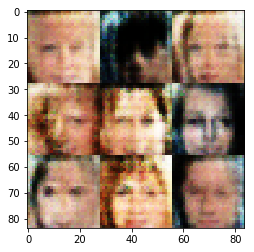

Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 3.9953
Epoch 1/1... Discriminator Loss: 3.7207... Generator Loss: 0.0401
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 2.0015
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 3.6095
Epoch 1/1... Discriminator Loss: 4.3146... Generator Loss: 0.0229
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 3.7883
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 4.1694
Epoch 1/1... Discriminator Loss: 5.0675... Generator Loss: 0.0101
Epoch 1/1... Discriminator Loss: 0.3348... Generator Loss: 6.0873
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.3804


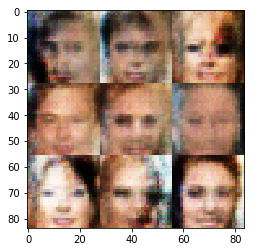

Epoch 1/1... Discriminator Loss: 3.8765... Generator Loss: 0.0315
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 2.7361
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 3.6549
Epoch 1/1... Discriminator Loss: 3.9531... Generator Loss: 0.0398
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 4.7014
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 3.1816
Epoch 1/1... Discriminator Loss: 3.4641... Generator Loss: 0.0733
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 4.0650
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 6.9375
Epoch 1/1... Discriminator Loss: 3.4454... Generator Loss: 0.0502


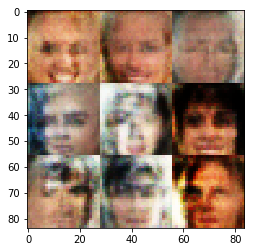

Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 5.8842
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.4845
Epoch 1/1... Discriminator Loss: 3.5094... Generator Loss: 0.0623
Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 6.6638
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 7.0410
Epoch 1/1... Discriminator Loss: 3.5757... Generator Loss: 0.0496
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 2.8691
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 2.8813
Epoch 1/1... Discriminator Loss: 5.6768... Generator Loss: 0.0066
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 4.9594


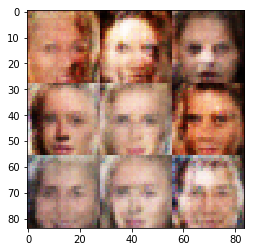

Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 4.5878
Epoch 1/1... Discriminator Loss: 5.0751... Generator Loss: 0.0112
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 3.1742
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.6166
Epoch 1/1... Discriminator Loss: 3.7615... Generator Loss: 0.0360
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 4.7903
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 4.8009
Epoch 1/1... Discriminator Loss: 3.5670... Generator Loss: 0.0440
Epoch 1/1... Discriminator Loss: 0.5212... Generator Loss: 3.2772
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 5.7562


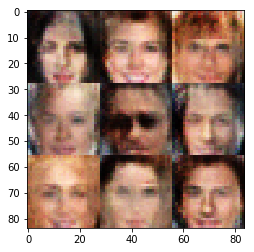

Epoch 1/1... Discriminator Loss: 4.3510... Generator Loss: 0.0253
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 1.8147
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 3.3706
Epoch 1/1... Discriminator Loss: 3.7080... Generator Loss: 0.0386
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 4.1710
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 4.8661
Epoch 1/1... Discriminator Loss: 3.9507... Generator Loss: 0.0291
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 4.1178
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 8.4650
Epoch 1/1... Discriminator Loss: 3.3684... Generator Loss: 0.0641


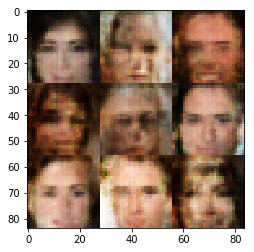

Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 3.6417
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.8261
Epoch 1/1... Discriminator Loss: 4.9257... Generator Loss: 0.0115
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 4.8985
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 4.1822... Generator Loss: 0.0243
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 3.7272
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 5.4953
Epoch 1/1... Discriminator Loss: 4.5372... Generator Loss: 0.0184
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 3.8938


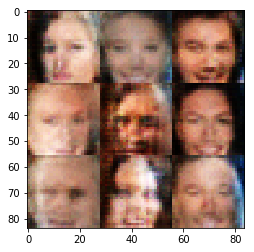

Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 4.4898
Epoch 1/1... Discriminator Loss: 3.9225... Generator Loss: 0.0332
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 4.0367
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 4.6736
Epoch 1/1... Discriminator Loss: 5.0017... Generator Loss: 0.0101
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 3.8299
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 5.2696
Epoch 1/1... Discriminator Loss: 3.9286... Generator Loss: 0.0358
Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 4.8176
Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 3.7639


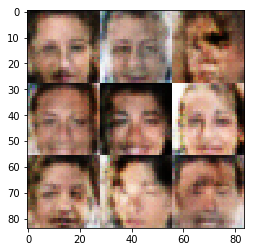

Epoch 1/1... Discriminator Loss: 3.8944... Generator Loss: 0.0337
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.6865
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 4.2124
Epoch 1/1... Discriminator Loss: 3.5771... Generator Loss: 0.0449
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 4.4221
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 2.4661
Epoch 1/1... Discriminator Loss: 3.7940... Generator Loss: 0.0373
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 3.3740
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 6.1847
Epoch 1/1... Discriminator Loss: 4.6331... Generator Loss: 0.0150


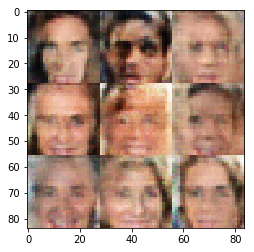

Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 4.9670
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 5.6510
Epoch 1/1... Discriminator Loss: 3.7522... Generator Loss: 0.0367
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 5.3518
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 6.8933
Epoch 1/1... Discriminator Loss: 3.5176... Generator Loss: 0.0554
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 3.7972
Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 4.9146
Epoch 1/1... Discriminator Loss: 3.8258... Generator Loss: 0.0334
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 3.6949


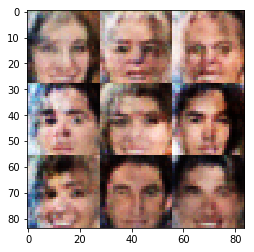

Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 4.4394
Epoch 1/1... Discriminator Loss: 4.4732... Generator Loss: 0.0208
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 6.0231
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 7.7655
Epoch 1/1... Discriminator Loss: 3.1468... Generator Loss: 0.0784
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 3.5682
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 4.7941
Epoch 1/1... Discriminator Loss: 4.2631... Generator Loss: 0.0254
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 3.4818
Epoch 1/1... Discriminator Loss: 0.6015... Generator Loss: 6.6726


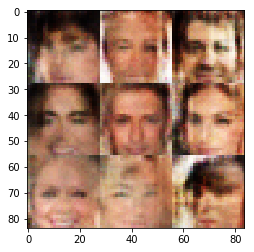

Epoch 1/1... Discriminator Loss: 5.3162... Generator Loss: 0.0106
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 4.1210
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 5.4796
Epoch 1/1... Discriminator Loss: 5.6919... Generator Loss: 0.0054
Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 3.7413
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 3.1353
Epoch 1/1... Discriminator Loss: 4.8635... Generator Loss: 0.0158
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 5.1177
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 4.5014
Epoch 1/1... Discriminator Loss: 3.3642... Generator Loss: 0.0560


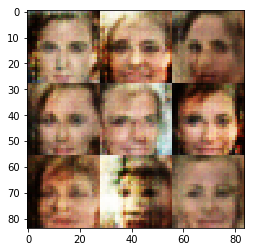

Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 4.5310
Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 5.4409
Epoch 1/1... Discriminator Loss: 4.5749... Generator Loss: 0.0165
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 5.9874
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 3.7226
Epoch 1/1... Discriminator Loss: 5.4734... Generator Loss: 0.0084
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 2.5594
Epoch 1/1... Discriminator Loss: 3.4444... Generator Loss: 0.0514
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.4686


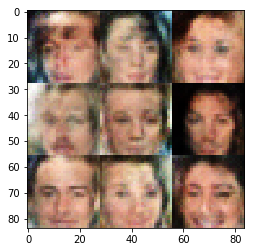

Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 3.4109
Epoch 1/1... Discriminator Loss: 4.6722... Generator Loss: 0.0155
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 4.5728
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 5.6048
Epoch 1/1... Discriminator Loss: 5.0626... Generator Loss: 0.0104
Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 3.7717
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 2.1781
Epoch 1/1... Discriminator Loss: 4.0987... Generator Loss: 0.0258
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 4.5385
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6026


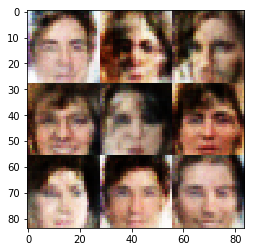

Epoch 1/1... Discriminator Loss: 4.5309... Generator Loss: 0.0179
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 5.0000
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 6.7702
Epoch 1/1... Discriminator Loss: 3.7977... Generator Loss: 0.0370
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 3.6471
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 4.3071
Epoch 1/1... Discriminator Loss: 4.8666... Generator Loss: 0.0146
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 2.2021
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 2.3615
Epoch 1/1... Discriminator Loss: 3.4898... Generator Loss: 0.0558


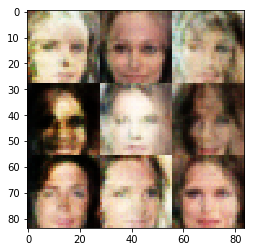

Epoch 1/1... Discriminator Loss: 0.3595... Generator Loss: 3.9352
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 4.0600
Epoch 1/1... Discriminator Loss: 3.6762... Generator Loss: 0.0435
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 5.8618
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 4.2306
Epoch 1/1... Discriminator Loss: 4.2085... Generator Loss: 0.0242
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 4.8016
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 5.9410
Epoch 1/1... Discriminator Loss: 5.3116... Generator Loss: 0.0100
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 3.3624


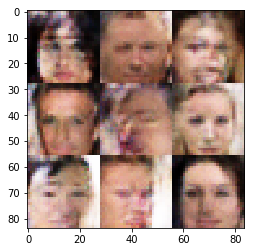

Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 3.4620
Epoch 1/1... Discriminator Loss: 5.8097... Generator Loss: 0.0050
Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 5.2692
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 1.7912
Epoch 1/1... Discriminator Loss: 4.8309... Generator Loss: 0.0149
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 4.3310
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 2.6258
Epoch 1/1... Discriminator Loss: 4.0592... Generator Loss: 0.0270
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 4.6035
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 3.5862


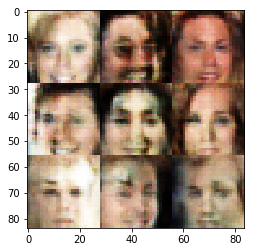

Epoch 1/1... Discriminator Loss: 4.4021... Generator Loss: 0.0199
Epoch 1/1... Discriminator Loss: 0.3643... Generator Loss: 4.4224
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 5.7109
Epoch 1/1... Discriminator Loss: 4.2292... Generator Loss: 0.0261
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 4.9926
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 3.3433
Epoch 1/1... Discriminator Loss: 4.6434... Generator Loss: 0.0152
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 3.7062
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 4.5511
Epoch 1/1... Discriminator Loss: 3.5531... Generator Loss: 0.0516


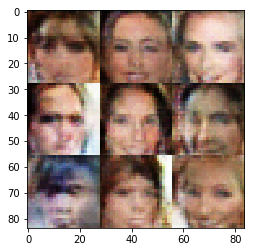

Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 2.8691
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 5.0900
Epoch 1/1... Discriminator Loss: 4.9749... Generator Loss: 0.0137
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 3.7938
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 3.0009
Epoch 1/1... Discriminator Loss: 4.1628... Generator Loss: 0.0262
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.8987
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 2.5543
Epoch 1/1... Discriminator Loss: 4.7758... Generator Loss: 0.0130
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 3.6069


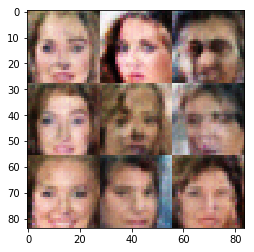

Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 5.7548
Epoch 1/1... Discriminator Loss: 3.5940... Generator Loss: 0.0448
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 3.7981
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 4.8990
Epoch 1/1... Discriminator Loss: 4.0322... Generator Loss: 0.0304
Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 4.3623
Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 6.3763
Epoch 1/1... Discriminator Loss: 3.9716... Generator Loss: 0.0316
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 4.4891
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 5.2262


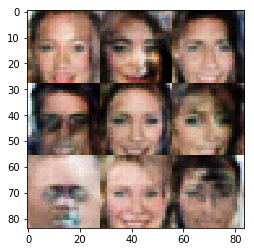

Epoch 1/1... Discriminator Loss: 4.0689... Generator Loss: 0.0275
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 3.6684
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 4.6125
Epoch 1/1... Discriminator Loss: 5.7277... Generator Loss: 0.0055
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 2.2651
Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 3.2858
Epoch 1/1... Discriminator Loss: 4.4859... Generator Loss: 0.0219
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 4.3993
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 3.6476
Epoch 1/1... Discriminator Loss: 5.6729... Generator Loss: 0.0056


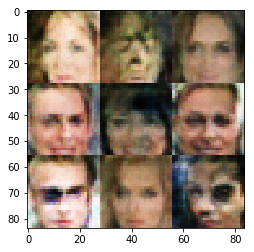

Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 3.7573
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 6.4621
Epoch 1/1... Discriminator Loss: 4.1255... Generator Loss: 0.0246
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 7.5326
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 4.6311
Epoch 1/1... Discriminator Loss: 4.6534... Generator Loss: 0.0149
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 3.9078
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 3.2366
Epoch 1/1... Discriminator Loss: 4.5593... Generator Loss: 0.0177
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 4.3081


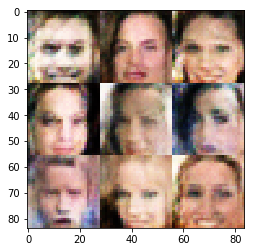

Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.1165
Epoch 1/1... Discriminator Loss: 3.3396... Generator Loss: 0.0576
Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 5.0092
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 5.8952
Epoch 1/1... Discriminator Loss: 5.6435... Generator Loss: 0.0063
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 5.8524
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 6.3604
Epoch 1/1... Discriminator Loss: 4.8383... Generator Loss: 0.0155
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 5.0293
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 6.1830


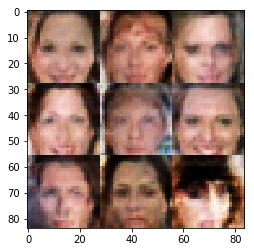

Epoch 1/1... Discriminator Loss: 4.1971... Generator Loss: 0.0235
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 4.2766
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 4.2599
Epoch 1/1... Discriminator Loss: 3.8784... Generator Loss: 0.0323
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 6.4388
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 4.5578
Epoch 1/1... Discriminator Loss: 3.4785... Generator Loss: 0.0494
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 4.3984
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 6.4589
Epoch 1/1... Discriminator Loss: 4.3652... Generator Loss: 0.0213


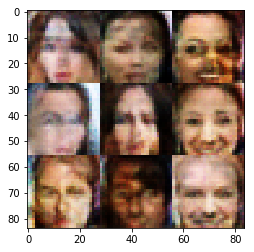

Epoch 1/1... Discriminator Loss: 0.3371... Generator Loss: 5.4455
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 4.1805
Epoch 1/1... Discriminator Loss: 4.4178... Generator Loss: 0.0204
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 2.5603
Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 4.0880
Epoch 1/1... Discriminator Loss: 4.6307... Generator Loss: 0.0164
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.2777
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 6.1835
Epoch 1/1... Discriminator Loss: 4.2731... Generator Loss: 0.0234
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 3.5098


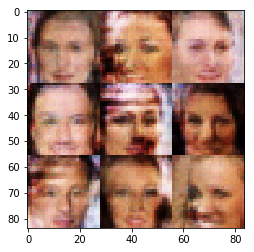

Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.4468
Epoch 1/1... Discriminator Loss: 4.9656... Generator Loss: 0.0111
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 3.8544
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 4.4610
Epoch 1/1... Discriminator Loss: 3.3971... Generator Loss: 0.0602
Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 4.1233
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 3.8185
Epoch 1/1... Discriminator Loss: 3.9751... Generator Loss: 0.0294
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 3.5587
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 3.8983


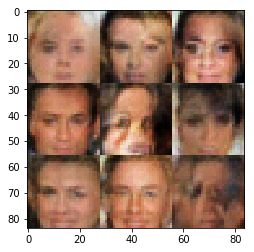

Epoch 1/1... Discriminator Loss: 3.9549... Generator Loss: 0.0349
Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 4.8482
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 4.0096
Epoch 1/1... Discriminator Loss: 5.1157... Generator Loss: 0.0093
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 6.0830
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 5.0723
Epoch 1/1... Discriminator Loss: 3.9014... Generator Loss: 0.0335
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 4.2473
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 2.1390
Epoch 1/1... Discriminator Loss: 4.0173... Generator Loss: 0.0356


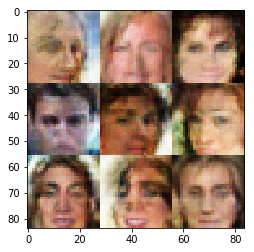

Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 5.0024
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 3.2211
Epoch 1/1... Discriminator Loss: 4.4602... Generator Loss: 0.0179
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 4.9015
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 2.9752
Epoch 1/1... Discriminator Loss: 3.8785... Generator Loss: 0.0333
Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 4.4621
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 7.0562
Epoch 1/1... Discriminator Loss: 4.8709... Generator Loss: 0.0127
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 5.3480


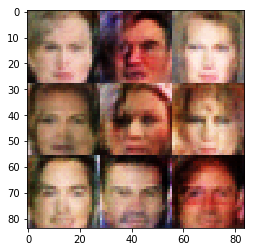

Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 5.5607
Epoch 1/1... Discriminator Loss: 5.5729... Generator Loss: 0.0077
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 3.5591
Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 4.3134
Epoch 1/1... Discriminator Loss: 3.7542... Generator Loss: 0.0416
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.7206
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 4.0231... Generator Loss: 0.0350
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 4.0841
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 7.1406


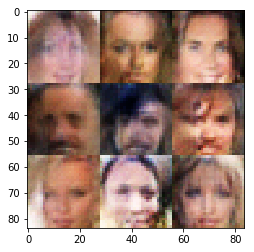

Epoch 1/1... Discriminator Loss: 3.8320... Generator Loss: 0.0348
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 4.3734
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 2.7799
Epoch 1/1... Discriminator Loss: 4.1471... Generator Loss: 0.0261
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 6.4873
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 4.2085
Epoch 1/1... Discriminator Loss: 4.2090... Generator Loss: 0.0250
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 3.1246
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 5.1472
Epoch 1/1... Discriminator Loss: 5.4297... Generator Loss: 0.0091


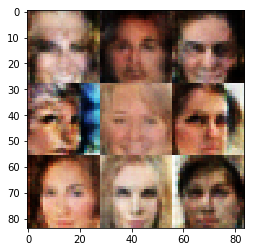

Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 6.2606
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 3.7874
Epoch 1/1... Discriminator Loss: 4.8024... Generator Loss: 0.0134
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 5.1073
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 4.4657
Epoch 1/1... Discriminator Loss: 4.3551... Generator Loss: 0.0198
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 3.7264
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 3.9601
Epoch 1/1... Discriminator Loss: 4.0978... Generator Loss: 0.0289
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 3.3419


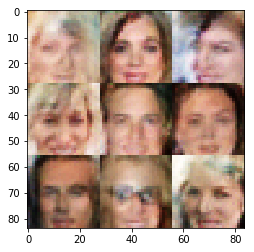

Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 4.9574
Epoch 1/1... Discriminator Loss: 3.9575... Generator Loss: 0.0491
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 5.7576
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 4.5978
Epoch 1/1... Discriminator Loss: 4.4794... Generator Loss: 0.0197
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 3.6485
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 2.3702
Epoch 1/1... Discriminator Loss: 5.0522... Generator Loss: 0.0097
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 5.8831
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 3.9994


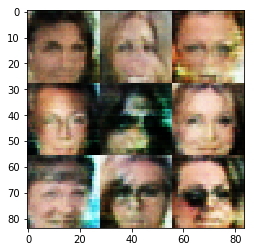

Epoch 1/1... Discriminator Loss: 3.5870... Generator Loss: 0.0545
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 4.2544
Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 2.4851
Epoch 1/1... Discriminator Loss: 5.1233... Generator Loss: 0.0098
Epoch 1/1... Discriminator Loss: 0.3601... Generator Loss: 3.6849
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 4.5708
Epoch 1/1... Discriminator Loss: 5.2167... Generator Loss: 0.0088
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 4.8927
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 4.5700
Epoch 1/1... Discriminator Loss: 4.1484... Generator Loss: 0.0262


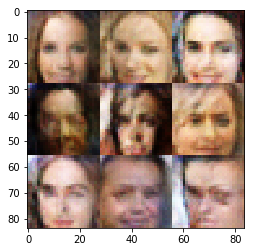

Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 2.8352
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 3.2551
Epoch 1/1... Discriminator Loss: 5.8191... Generator Loss: 0.0053
Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 1.8583
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 6.0270
Epoch 1/1... Discriminator Loss: 4.4096... Generator Loss: 0.0195
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 4.5261
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 3.7291
Epoch 1/1... Discriminator Loss: 5.5436... Generator Loss: 0.0073
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 3.1997


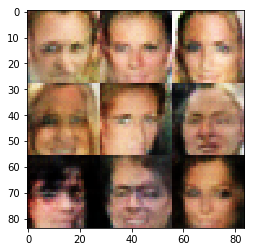

Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 6.4978
Epoch 1/1... Discriminator Loss: 4.0223... Generator Loss: 0.0310
Epoch 1/1... Discriminator Loss: 0.3770... Generator Loss: 4.4841
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 3.6490
Epoch 1/1... Discriminator Loss: 4.2309... Generator Loss: 0.0254
Epoch 1/1... Discriminator Loss: 3.9505... Generator Loss: 0.0296
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 4.3227
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.4800


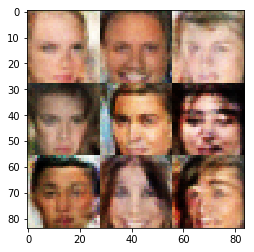

Epoch 1/1... Discriminator Loss: 4.3436... Generator Loss: 0.0218
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 5.0118
Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 3.7461
Epoch 1/1... Discriminator Loss: 4.4665... Generator Loss: 0.0184
Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 4.5399
Epoch 1/1... Discriminator Loss: 0.3981... Generator Loss: 3.5929
Epoch 1/1... Discriminator Loss: 4.2363... Generator Loss: 0.0236
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 2.3095
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 3.3327
Epoch 1/1... Discriminator Loss: 6.0427... Generator Loss: 0.0040


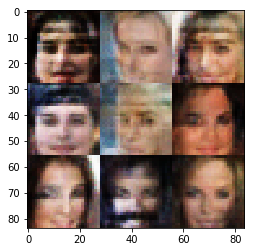

Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 4.3232
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 4.7856
Epoch 1/1... Discriminator Loss: 4.7173... Generator Loss: 0.0153
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 5.5970
Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 3.7683
Epoch 1/1... Discriminator Loss: 5.7163... Generator Loss: 0.0072
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 3.1508
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 3.7226
Epoch 1/1... Discriminator Loss: 3.9614... Generator Loss: 0.0314
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 4.4217


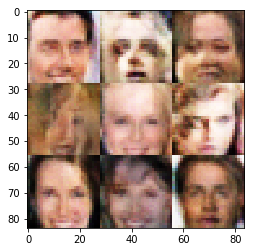

Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 4.1631
Epoch 1/1... Discriminator Loss: 4.4932... Generator Loss: 0.0178
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 4.1248
Epoch 1/1... Discriminator Loss: 0.3308... Generator Loss: 6.2529
Epoch 1/1... Discriminator Loss: 4.4716... Generator Loss: 0.0186
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 2.8049
Epoch 1/1... Discriminator Loss: 0.3587... Generator Loss: 5.1769
Epoch 1/1... Discriminator Loss: 3.4502... Generator Loss: 0.0503
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 4.2852
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.2608


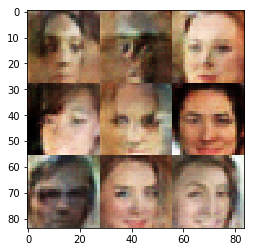

Epoch 1/1... Discriminator Loss: 3.5890... Generator Loss: 0.0434
Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 4.2497
Epoch 1/1... Discriminator Loss: 0.3915... Generator Loss: 5.2415
Epoch 1/1... Discriminator Loss: 3.2241... Generator Loss: 0.0636
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 2.9820
Epoch 1/1... Discriminator Loss: 0.3643... Generator Loss: 3.8091
Epoch 1/1... Discriminator Loss: 4.7646... Generator Loss: 0.0138
Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 3.3818
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 4.6604
Epoch 1/1... Discriminator Loss: 5.6706... Generator Loss: 0.0056


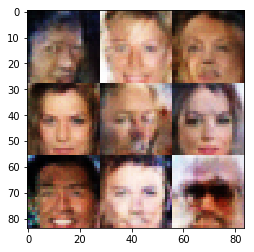

Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.3556
Epoch 1/1... Discriminator Loss: 0.3583... Generator Loss: 3.6937
Epoch 1/1... Discriminator Loss: 3.7915... Generator Loss: 0.0417
Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 4.8545
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 3.9245
Epoch 1/1... Discriminator Loss: 4.0130... Generator Loss: 0.0301
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 3.2282
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.4698
Epoch 1/1... Discriminator Loss: 4.2991... Generator Loss: 0.0211
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 3.8886


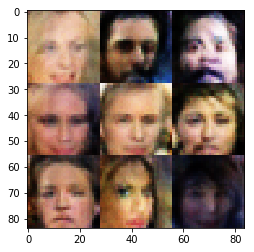

Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 3.1362
Epoch 1/1... Discriminator Loss: 6.2397... Generator Loss: 0.0033
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 4.0999
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 5.8562
Epoch 1/1... Discriminator Loss: 4.3299... Generator Loss: 0.0218
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 3.8572
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 3.8927
Epoch 1/1... Discriminator Loss: 4.7657... Generator Loss: 0.0143
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 3.8488
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 4.2228


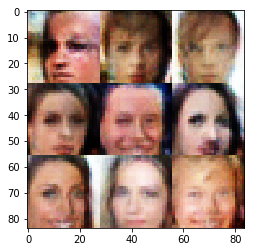

Epoch 1/1... Discriminator Loss: 5.4517... Generator Loss: 0.0063
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 3.8369
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 4.0051
Epoch 1/1... Discriminator Loss: 3.6230... Generator Loss: 0.0436
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 5.4022
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 5.2627
Epoch 1/1... Discriminator Loss: 5.1234... Generator Loss: 0.0110
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 3.6050
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 7.2899
Epoch 1/1... Discriminator Loss: 4.5951... Generator Loss: 0.0208


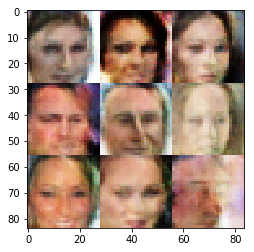

Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 4.5771
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 4.0159
Epoch 1/1... Discriminator Loss: 4.2954... Generator Loss: 0.0222
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 3.4059
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 2.9722
Epoch 1/1... Discriminator Loss: 5.5517... Generator Loss: 0.0077
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 2.6884
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 3.3657
Epoch 1/1... Discriminator Loss: 5.7905... Generator Loss: 0.0051
Epoch 1/1... Discriminator Loss: 0.4160... Generator Loss: 4.5215


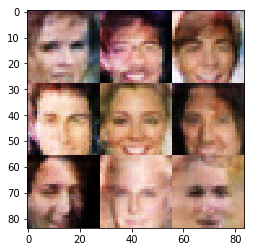

Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 4.8178
Epoch 1/1... Discriminator Loss: 4.9104... Generator Loss: 0.0122
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 2.7774
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 5.1552
Epoch 1/1... Discriminator Loss: 5.0501... Generator Loss: 0.0100
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 6.3236
Epoch 1/1... Discriminator Loss: 0.3486... Generator Loss: 4.7794
Epoch 1/1... Discriminator Loss: 3.8828... Generator Loss: 0.0347
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.5745
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 2.4586


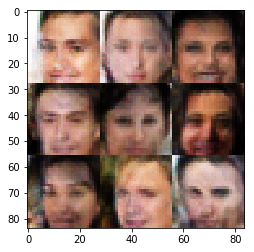

Epoch 1/1... Discriminator Loss: 4.3974... Generator Loss: 0.0200
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 3.5690
Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 5.3805
Epoch 1/1... Discriminator Loss: 4.5613... Generator Loss: 0.0170
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 3.6495
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 5.4499
Epoch 1/1... Discriminator Loss: 4.5521... Generator Loss: 0.0159
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 5.2913
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 4.9149
Epoch 1/1... Discriminator Loss: 4.7944... Generator Loss: 0.0152


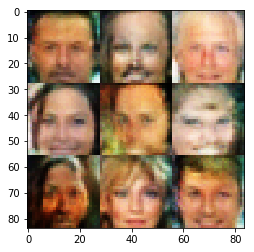

Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 4.6623
Epoch 1/1... Discriminator Loss: 0.3495... Generator Loss: 4.0332
Epoch 1/1... Discriminator Loss: 5.2700... Generator Loss: 0.0083
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 5.3520
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.0904
Epoch 1/1... Discriminator Loss: 4.7242... Generator Loss: 0.0136
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 3.2262
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 4.5995
Epoch 1/1... Discriminator Loss: 4.4356... Generator Loss: 0.0187
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 4.3061


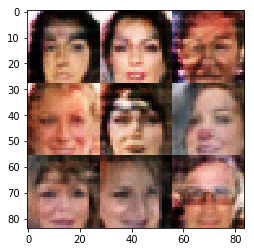

Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 3.5892
Epoch 1/1... Discriminator Loss: 3.4832... Generator Loss: 0.0497
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 4.4734
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 3.9057
Epoch 1/1... Discriminator Loss: 3.2415... Generator Loss: 0.0812
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 3.8138
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 2.4493
Epoch 1/1... Discriminator Loss: 4.2638... Generator Loss: 0.0244
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 4.6117
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 4.4839


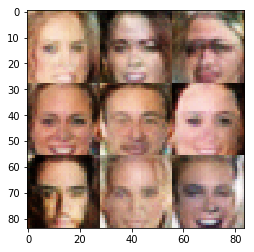

Epoch 1/1... Discriminator Loss: 4.8581... Generator Loss: 0.0135
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 4.3261
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 3.8958
Epoch 1/1... Discriminator Loss: 3.6481... Generator Loss: 0.0402
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 3.7476
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 4.3595
Epoch 1/1... Discriminator Loss: 5.1990... Generator Loss: 0.0086
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 4.5556
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 1.9397
Epoch 1/1... Discriminator Loss: 5.1008... Generator Loss: 0.0098


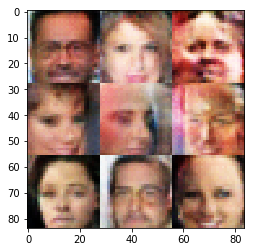

Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 3.6426
Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 4.3408
Epoch 1/1... Discriminator Loss: 3.8068... Generator Loss: 0.0380
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 5.5924
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 4.3954
Epoch 1/1... Discriminator Loss: 4.4551... Generator Loss: 0.0220
Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 3.0960
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 3.5545
Epoch 1/1... Discriminator Loss: 3.9095... Generator Loss: 0.0366
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.6453


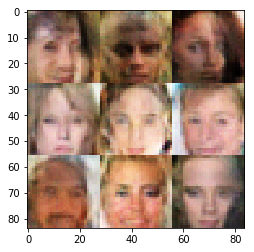

Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 3.7037
Epoch 1/1... Discriminator Loss: 4.1187... Generator Loss: 0.0259
Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 4.3727
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 5.1042
Epoch 1/1... Discriminator Loss: 4.3309... Generator Loss: 0.0219
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 4.5756
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 3.3654
Epoch 1/1... Discriminator Loss: 4.5953... Generator Loss: 0.0174
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 6.4418
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 3.8011


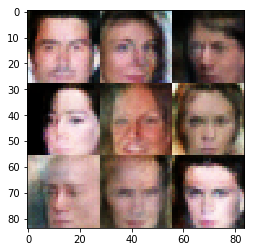

Epoch 1/1... Discriminator Loss: 4.8710... Generator Loss: 0.0147
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 3.8337
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 3.5935
Epoch 1/1... Discriminator Loss: 4.7887... Generator Loss: 0.0156
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 3.3161
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 4.3591
Epoch 1/1... Discriminator Loss: 6.5883... Generator Loss: 0.0022
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 4.8170


In [ ]:
batch_size = 16
z_dim = 256
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
  losses=train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,celeba_dataset.shape, celeba_dataset.image_mode)
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.